In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
from collections import Counter
from functools import reduce
import ast

#For interactive plots 
import plotly.graph_objects as go #pip install plotly
import dash
from dash import dcc, html #pip install dash
from dash.dependencies import Input, Output #pip install dash-bootstrap-components

#load the statistical libraries
from statsmodels.stats import diagnostic
from scipy import stats

from src.data.utils import get_franchise_movies, get_franchise_data, get_inflation_rate, get_1_2_movies

In [2]:
movies_df = pd.read_csv('data/movie_metadata_with_tmdb.csv')


inflation_rate_df=get_inflation_rate()
franchise_df=get_franchise_movies(movies_df,inflation_rate_df,'data/missing_dates_manualsearch.csv')




franchise_data_df = get_franchise_data(franchise_df)
# average years between movies of a franchise
#franchise_data_df['average_years_bt_movies'] = franchise_data_df['franchise_length_years'] / (franchise_data_df['movie_count']-1)



In [3]:
franchise_df.dtypes

Wikipedia movie ID                                    int64
Freebase movie ID                                    object
Movie name                                           object
Movie release date                                   object
Movie runtime                                       float64
Movie languages (Freebase ID:name tuples)            object
Movie countries (Freebase ID:name tuples)            object
Movie genres (Freebase ID:name tuples)               object
tmdb_id                                             float64
collection_name                                      object
collection_id                                       float64
vote_count                                          float64
vote_average                                        float64
genres                                               object
budget                                              float64
run_time                                            float64
tmdb_origin_country                     

In [4]:
# def count_genre_diff(curr, prev):
#     if curr is None or prev is None:  # Handle NaN or None
#         return 0
#     curr_set, prev_set = set(curr), set(prev)
#     return len(curr_set.symmetric_difference(prev_set))  # Count differences

# # Apply the function while ensuring sorting
# franchise_df['genre_diff'] = (
#     franchise_df.groupby('collection_id', group_keys=False)
#     .apply(
#         lambda group: group.sort_values(by='movie_order')  # Sort locally
#         .assign(
#             genre_diff=lambda x: [
#                 count_genre_diff(curr, prev)
#                 for curr, prev in zip(x['genres'], x['genres'].shift(1))
#             ]
#         )
#     )['genre_diff']  # Extract the 'genre_diff' column
#     .reset_index(drop=True)  # Reset index to avoid misalignment
# )

# # difference relative de genre
# franchise_df['genre_diff_rel'] = franchise_df['genre_diff'] / franchise_df['genres'].apply(len)

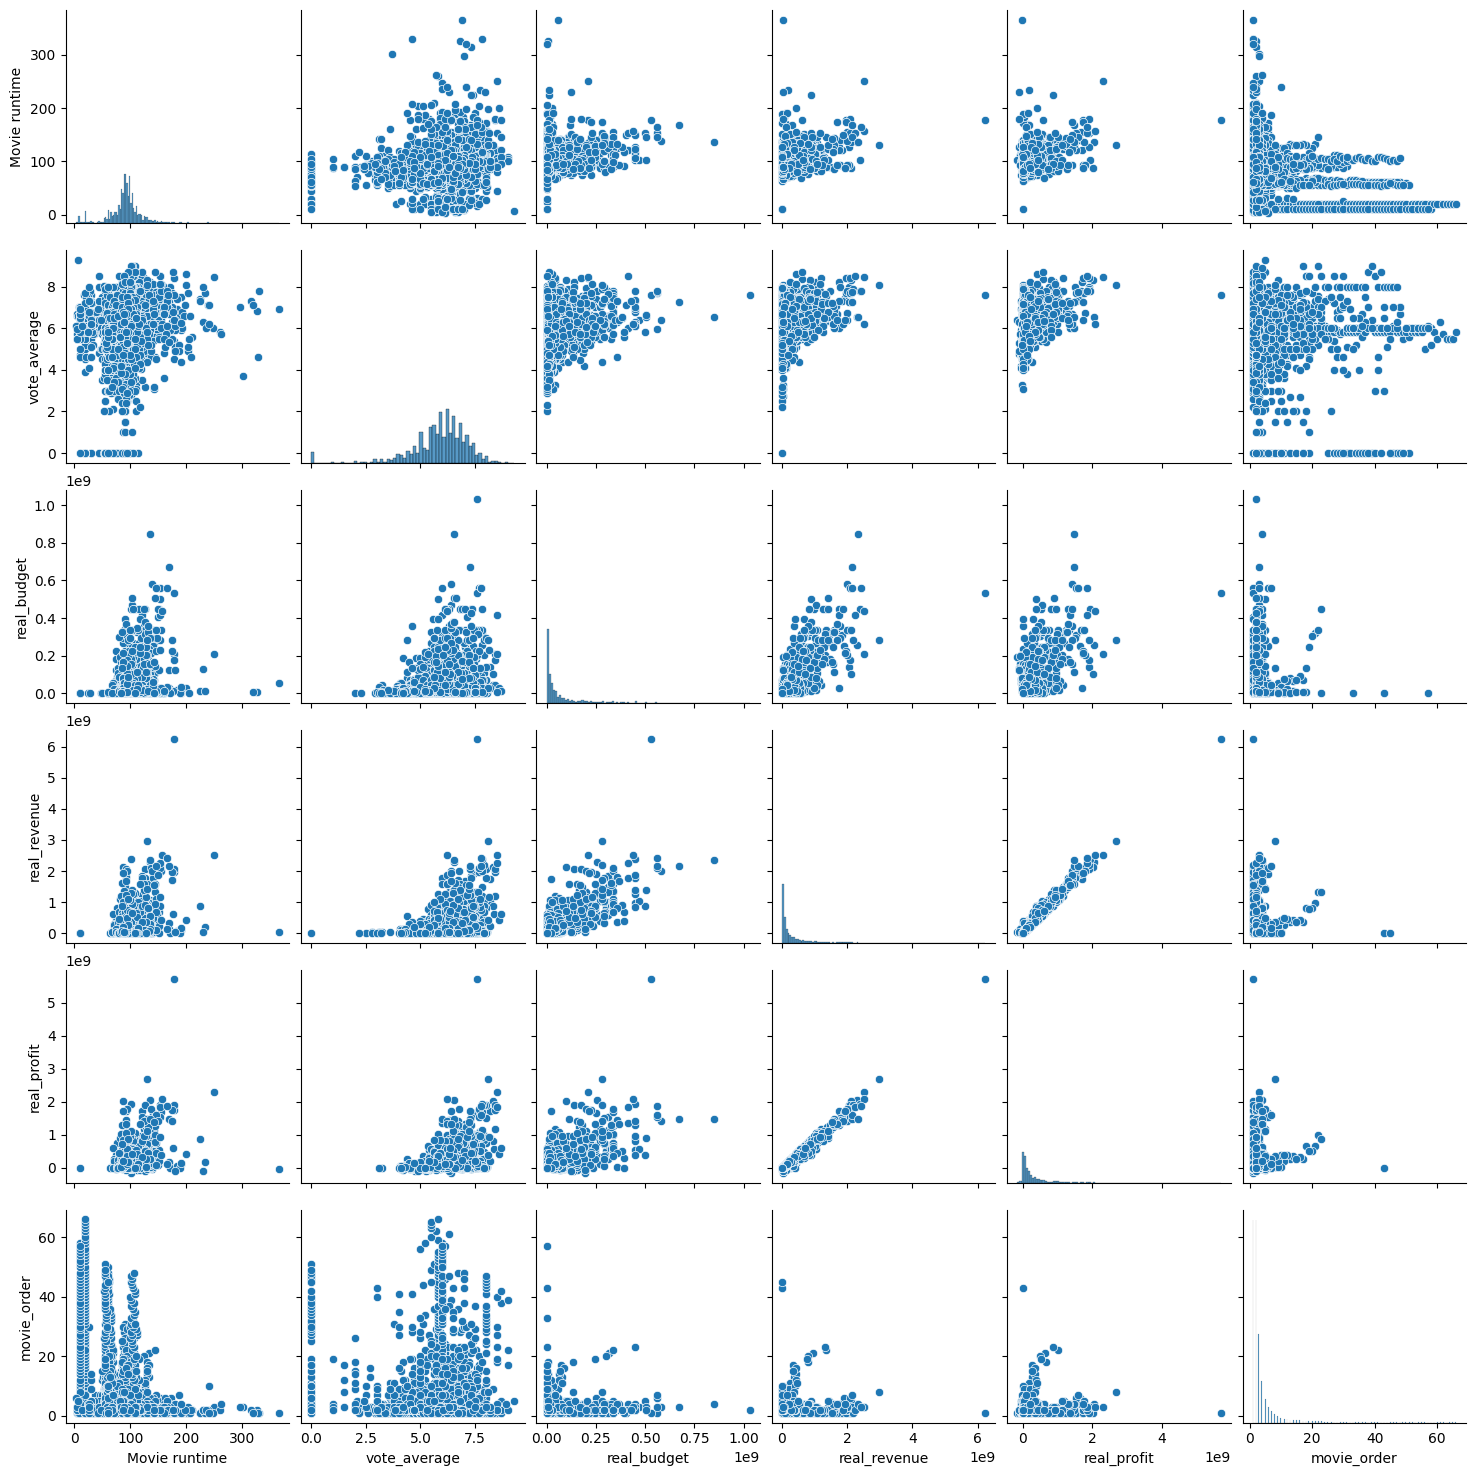

In [5]:
sns.pairplot(franchise_df[['Movie runtime','vote_average','real_budget','real_revenue','real_profit','movie_order']])

Text(0.5, 1.0, 'Pearson Correlation: 0.38\nSpearman Correlation: 0.40')

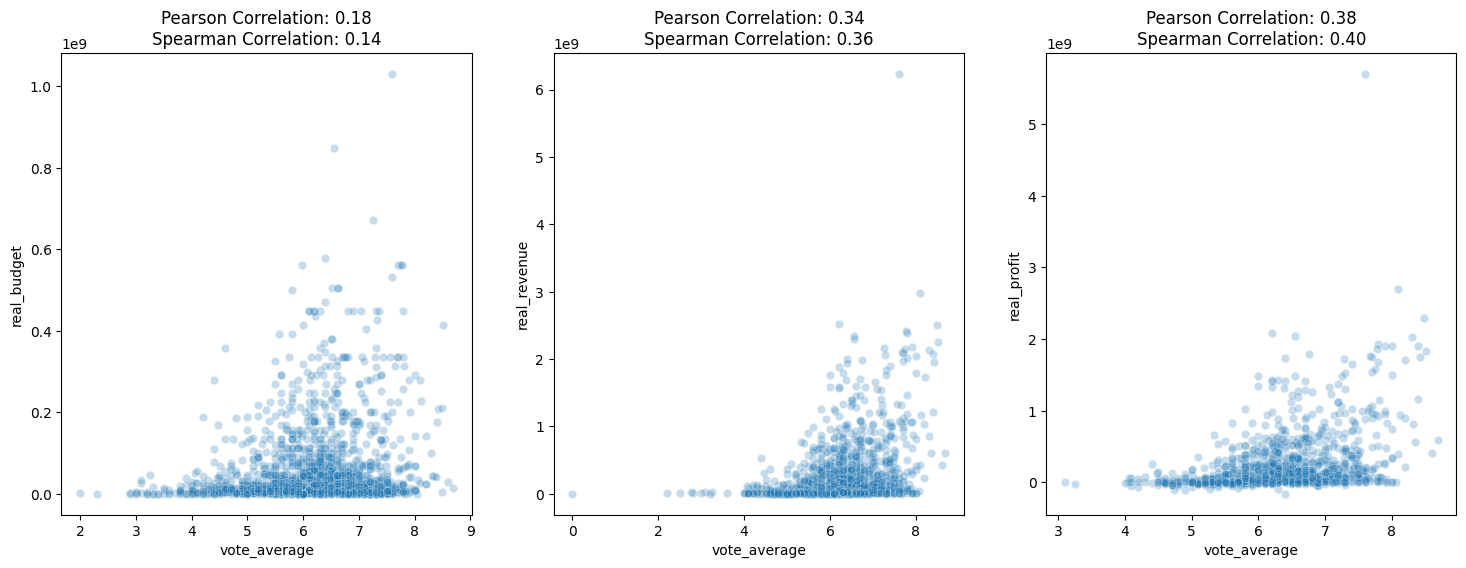

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
 
# scatter plot of the real budget and vote average
sns.scatterplot(x='vote_average', y='real_budget', data=franchise_df,alpha=.25, ax=axes[0])

# scatter plot of the real revenue and vote average
sns.scatterplot(x='vote_average', y='real_revenue', data=franchise_df,alpha=.25, ax=axes[1])

# scatter plot of the real profit and vote average
sns.scatterplot(x='vote_average', y='real_profit', data=franchise_df,alpha=.25, ax=axes[2])

# Calculate the person and spearmann correlation
person_corr = franchise_df[['vote_average','real_budget','real_revenue','real_profit']].corr(method='pearson')
spearman_corr = franchise_df[['vote_average','real_budget','real_revenue','real_profit']].corr(method='spearman')

axes[0].set_title(f'Pearson Correlation: {person_corr.iloc[0,1]:.2f}\nSpearman Correlation: {spearman_corr.iloc[0,1]:.2f}')
axes[1].set_title(f'Pearson Correlation: {person_corr.iloc[0,2]:.2f}\nSpearman Correlation: {spearman_corr.iloc[0,2]:.2f}')
axes[2].set_title(f'Pearson Correlation: {person_corr.iloc[0,3]:.2f}\nSpearman Correlation: {spearman_corr.iloc[0,3]:.2f}')

Text(0.5, 1.0, 'Pearson Correlation: -0.08\nSpearman Correlation: -0.07')

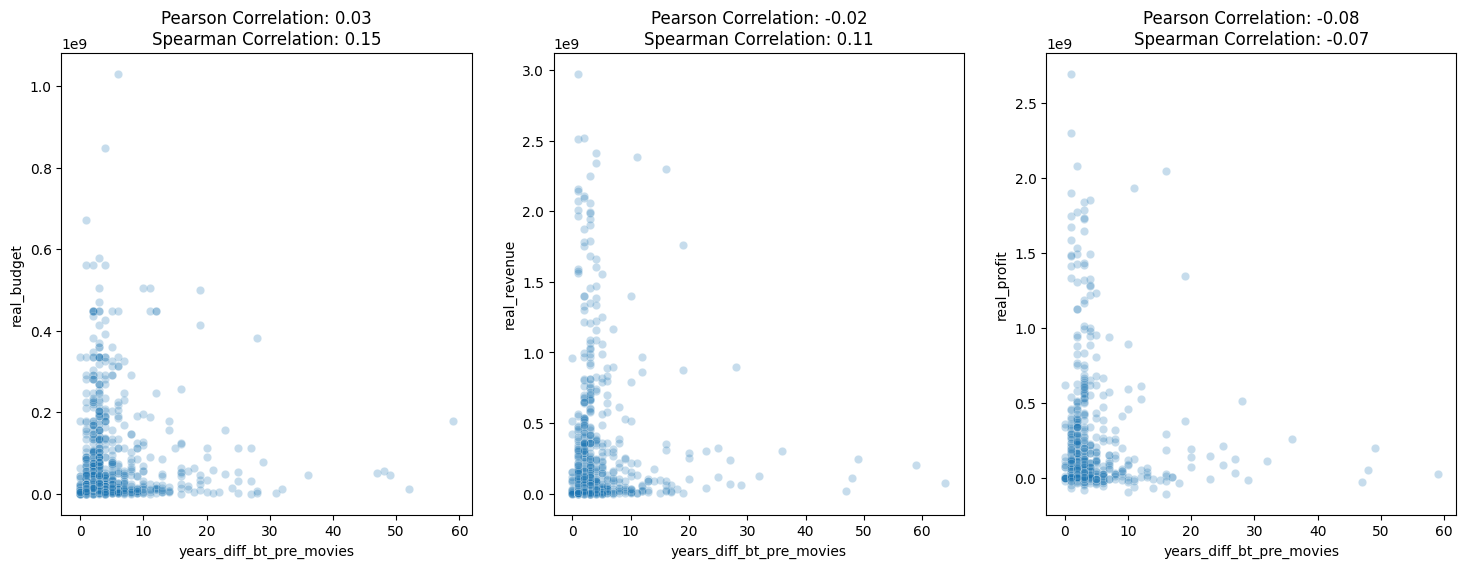

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
 
# scatter plot of the real budget and years diff bt pre movies
sns.scatterplot(x='years_diff_bt_pre_movies', y='real_budget', data=franchise_df,alpha=.25, ax=axes[0])

# scatter plot of the real revenue and years diff bt pre movies
sns.scatterplot(x='years_diff_bt_pre_movies', y='real_revenue', data=franchise_df,alpha=.25, ax=axes[1])

# scatter plot of the real profit and years diff bt pre movies
sns.scatterplot(x='years_diff_bt_pre_movies', y='real_profit', data=franchise_df,alpha=.25, ax=axes[2])

# Calculate the person and spearmann correlation
person_corr = franchise_df[['years_diff_bt_pre_movies','real_budget','real_revenue','real_profit']].corr(method='pearson')
spearman_corr = franchise_df[['years_diff_bt_pre_movies','real_budget','real_revenue','real_profit']].corr(method='spearman')

axes[0].set_title(f'Pearson Correlation: {person_corr.iloc[0,1]:.2f}\nSpearman Correlation: {spearman_corr.iloc[0,1]:.2f}')
axes[1].set_title(f'Pearson Correlation: {person_corr.iloc[0,2]:.2f}\nSpearman Correlation: {spearman_corr.iloc[0,2]:.2f}')
axes[2].set_title(f'Pearson Correlation: {person_corr.iloc[0,3]:.2f}\nSpearman Correlation: {spearman_corr.iloc[0,3]:.2f}')

Text(0.5, 1.0, 'Pearson Correlation: 0.08\nSpearman Correlation: 0.01')

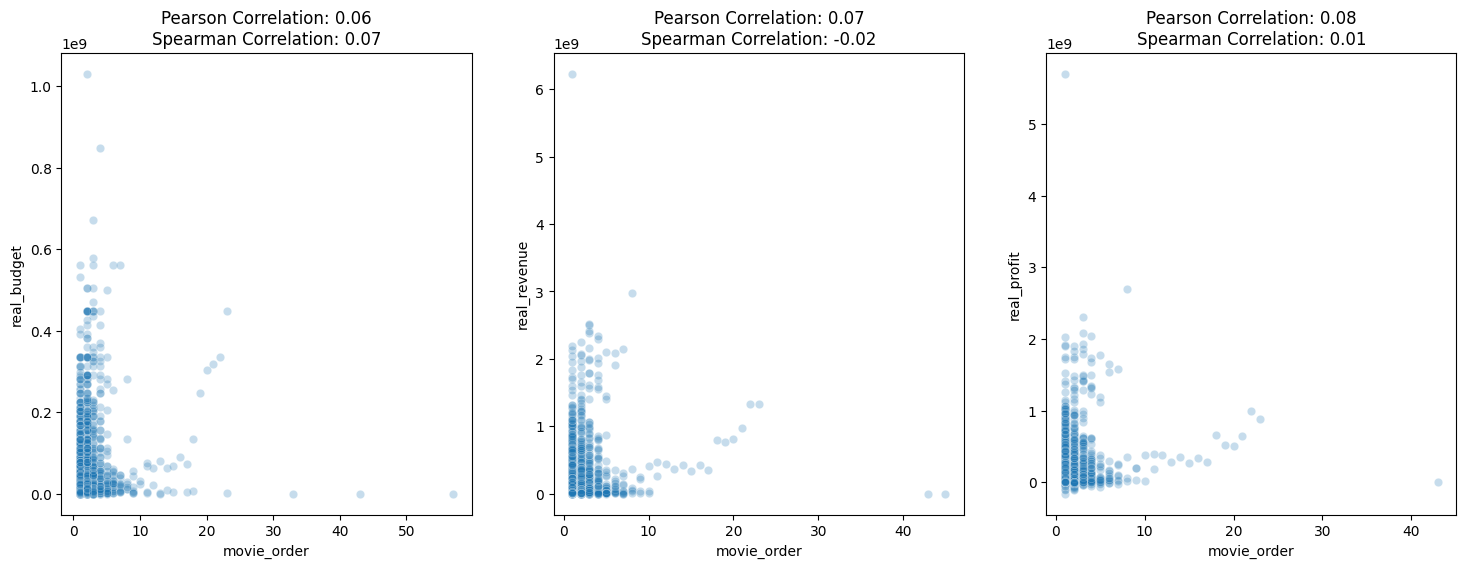

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
 
# scatter plot of the real budget and movie order
sns.scatterplot(x='movie_order', y='real_budget', data=franchise_df,alpha=.25, ax=axes[0])

# scatter plot of the real revenue and movie order
sns.scatterplot(x='movie_order', y='real_revenue', data=franchise_df,alpha=.25, ax=axes[1])

# scatter plot of the real profit and movie order
sns.scatterplot(x='movie_order', y='real_profit', data=franchise_df,alpha=.25, ax=axes[2])

# Calculate the person and spearmann correlation
person_corr = franchise_df[['movie_order','real_budget','real_revenue','real_profit']].corr(method='pearson')
spearman_corr = franchise_df[['movie_order','real_budget','real_revenue','real_profit']].corr(method='spearman')

axes[0].set_title(f'Pearson Correlation: {person_corr.iloc[0,1]:.2f}\nSpearman Correlation: {spearman_corr.iloc[0,1]:.2f}')
axes[1].set_title(f'Pearson Correlation: {person_corr.iloc[0,2]:.2f}\nSpearman Correlation: {spearman_corr.iloc[0,2]:.2f}')
axes[2].set_title(f'Pearson Correlation: {person_corr.iloc[0,3]:.2f}\nSpearman Correlation: {spearman_corr.iloc[0,3]:.2f}')

In [9]:
# analysis of the difference between the first en second movies
f_1_2=get_franchise_movies(movies_df,inflation_rate_df,'data/missing_dates_manualsearch.csv')

def has_genre_diff(curr, prev):
    if curr is None or prev is None:  # Handle NaN or None
        return False  # No comparison possible
    curr_set, prev_set = set(curr), set(prev)
    return curr_set != prev_set  # Return True if the sets are different

# Apply the function while ensuring sorting
f_1_2['genre_diff'] = (
    f_1_2.groupby('collection_id', group_keys=False)
    .apply(
        lambda group: group.sort_values(by='movie_order')  # Sort locally
        .assign(
            genre_diff=lambda x: [
                has_genre_diff(curr, prev)
                for curr, prev in zip(x['genres'], x['genres'].shift(1))
            ]
        )
    )['genre_diff']  # Extract the 'genre_diff' column
    .reset_index(drop=True)  # Reset index to avoid misalignment
)


fsm_df = f_1_2[(f_1_2['movie_order'] == 1) | (f_1_2['movie_order'] == 2)]
fsm_df = fsm_df[['Movie name','collection_name','movie_order','real_budget','real_revenue','real_profit','years_diff_bt_pre_movies','genre_diff']]
fsm_df.sort_values(by='movie_order',inplace=True)
sm_df = fsm_df[fsm_df['movie_order'] == 2]
sm_df['profit_over_budget'] = sm_df['real_profit'] / sm_df['real_budget']
sm_df=sm_df.merge(fsm_df[(fsm_df['movie_order'] == 1)][['collection_name','real_profit','real_budget']],on='collection_name',suffixes=('_movie2','_movie1'))
sm_df.dropna(subset=['real_profit_movie2'],inplace=True)
sm_df.dropna(subset=['real_profit_movie1'],inplace=True)

/var/folders/8q/3pfpy7tj5xqdr2spkvvmtngr0000gn/T/ipykernel_22223/74999627.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(
/var/folders/8q/3pfpy7tj5xqdr2spkvvmtngr0000gn/T/ipykernel_22223/74999627.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sm_df['profit_over_budget'] = sm_df['real_profit'] / sm_df['real_budget']


In [10]:
from statsmodels.tools import add_constant
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import statsmodels.api as sm

regre=get_1_2_movies(franchise_df)

def has_genre_diff_strings(genre_1, genre_2):
    if pd.isna(genre_1) or pd.isna(genre_2):  # Handle NaN
        return False  # No comparison possible
    set_1 = set(genre_1.split(", "))  # Convert string to set
    set_2 = set(genre_2.split(", "))  # Convert string to set
    return set_1 != set_2  # Return True if the sets are different

# Apply the function row-wise
regre['genre_diff'] = regre.apply(
    lambda row: has_genre_diff_strings(row['genres_1'], row['genres_2']), axis=1
)

regre=pd.get_dummies(regre, columns=['genre_diff'], drop_first=True)

regre=regre.dropna(subset=['real_profit_1'])
regre=regre.dropna(subset=['real_budget_2'])

# Define the features and the label
X = regre.drop(columns=['vote_count_2','Movie name_1','Movie name_2','Wikipedia movie ID_1','Wikipedia movie ID_2','real_profit_2','real_revenue_2','real_revenue_1','ratio_revenue_budget_1','ratio_revenue_budget_2','collection_name_1','collection_name_2','genres_1','genres_2','tmdb_origin_country_1','tmdb_origin_country_2','vote_average_2'])

y = regre['ratio_revenue_budget_2']

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Standardize the features
X_train_std = StandardScaler().fit_transform(X_train)

X_test_std = StandardScaler().fit(X_train).transform(X_test)


# Add a constant to the features (intercept term)
X_train_std = sm.add_constant(X_train_std)

# Fit the regression model
model = sm.OLS(Y_train, X_train_std).fit()

# Print the summary of the regression model
print(model.summary())

results_table = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.params[1:],
    'P-value': model.pvalues[1:]
})
print(results_table)

                              OLS Regression Results                              
Dep. Variable:     ratio_revenue_budget_2   R-squared:                         nan
Model:                                OLS   Adj. R-squared:                    nan
Method:                     Least Squares   F-statistic:                       nan
Date:                    Fri, 20 Dec 2024   Prob (F-statistic):                nan
Time:                            09:01:49   Log-Likelihood:                    nan
No. Observations:                     288   AIC:                               nan
Df Residuals:                         209   BIC:                               nan
Df Model:                              78                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       

In [11]:
X.dtypes

collection_id               float64
vote_count_1                float64
vote_average_1              float64
run_time_1                  float64
run_time_2                  float64
                             ...   
tmdb_origin_country_2_us      int64
tmdb_origin_country_2_xc      int64
tmdb_origin_country_2_yu      int64
same_genres                   int64
genre_diff_True                bool
Length: 163, dtype: object

In [12]:
results_table.sort_values(by='P-value', ascending=True)

,Feature,Coefficient,P-value
x1,collection_id,NaN,NaN
x2,vote_count_1,NaN,NaN
x3,vote_average_1,NaN,NaN
x4,run_time_1,NaN,NaN
x5,run_time_2,NaN,NaN
...,...,...,...
x159,tmdb_origin_country_2_us,NaN,NaN
x160,tmdb_origin_country_2_xc,NaN,NaN
x161,tmdb_origin_country_2_yu,NaN,NaN
x162,same_genres,NaN,NaN


/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


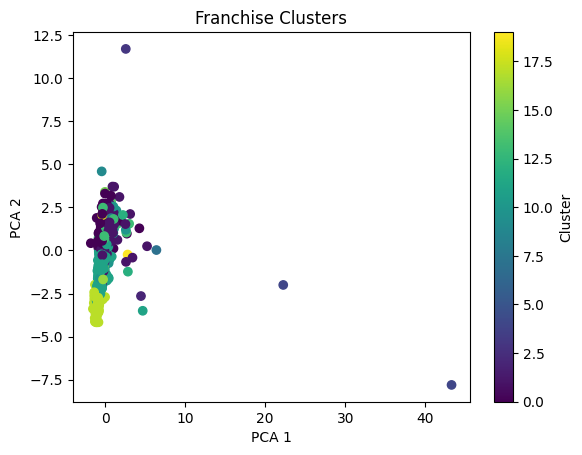

,collection_name,Cluster
35,Evil Dead Collection,0
27,28 Days/Weeks Later Collection,0
13,Cube Collection,0
20,Saw Collection,0
21,Blade Collection,0
5,The Godfather Collection,1
24,Lethal Weapon Collection,1
9,Ocean's Collection,1
32,Planet of the Apes (Original) Collection,1
23,The Pink Panther (Original) Collection,1


In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd



franchise_data_df = get_franchise_data(franchise_df)

# genre vecotrization
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(tokenizer=lambda x: x.split(", "))
genre_matrix = vectorizer.fit_transform(franchise_data_df['genres'])
genre_df = pd.DataFrame(genre_matrix.toarray(), columns=[f'genre_{col}' for col in vectorizer.get_feature_names_out()])
franchise_data_df = pd.concat([franchise_data_df, genre_df], axis=1)

vectorizer = CountVectorizer(tokenizer=lambda x: x.split(", "))
country_matrix = vectorizer.fit_transform(franchise_data_df['country'])
country_df = pd.DataFrame(country_matrix.toarray(), columns=[f'country_{col}' for col in vectorizer.get_feature_names_out()])
franchise_data_df = pd.concat([franchise_data_df, country_df], axis=1)

franchise_data_df['oldest_release_year'] = franchise_data_df['oldest_release'].dt.year
franchise_data_df['newest_release_year'] = franchise_data_df['newest_release'].dt.year

# Fill NaN in the 'revenue_avg' column with 0
franchise_data_df['revenue_avg'] = franchise_data_df['revenue_avg'].fillna(0)



# Load and preprocess dat
data = franchise_data_df.drop(columns=['collection_id','collection_name','genres','oldest_release','newest_release','franchise_length','revenue_avg','country','region'])

# Drop rows where any other column contains NaN
data = data.dropna()

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Apply K-Means
kmeans = KMeans(n_clusters=20, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Assign clusters back to franchise_data_df
franchise_data_df['Cluster'] = pd.NA  # Initialize Cluster column with NaN
franchise_data_df.loc[data.index, 'Cluster'] = clusters

    
# Dimensionality reduction for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis')
plt.title('Franchise Clusters')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.show()

# print the 5 first franchises of each cluster
franchise_data_df.groupby('Cluster')[['collection_name','Cluster']].head(5).sort_values(by='Cluster')



Franchise of the cluster of less than 10 movies:
     Cluster                        collection_name
505        2                   Before... Collection
19         3                  James Bond Collection
34         4  USA: Land of Opportunities Collection
150        4              The Millennium Collection
422        5           The Irony of Fate Collection
...      ...                                    ...
1587    <NA>           Poeten og Lillemor (Samling)
1588    <NA>                        The Rat Trilogy
1589    <NA>                Dark Shadows Collection
1590    <NA>               Maxim Trilogy Collection
1591    <NA>       Kaurismäki's Proletariat Trilogy

[1032 rows x 2 columns]


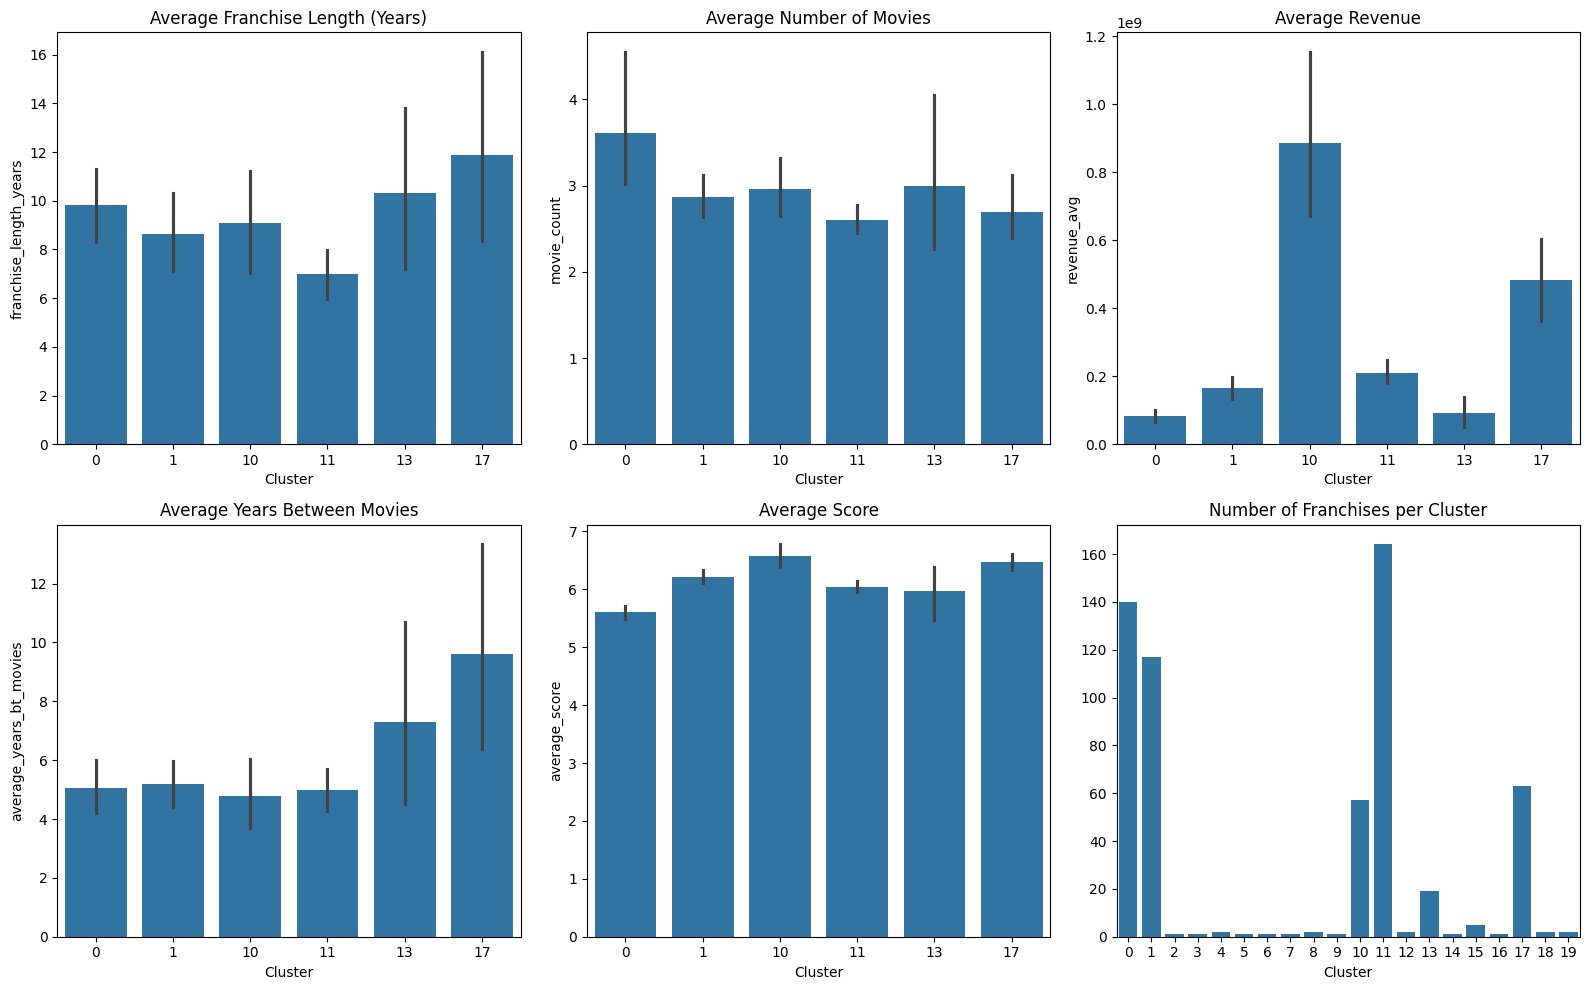

In [14]:
# Drop the cluster with less than 10 franchises idk if it is necessary
franchise_data_df_filt = franchise_data_df.groupby('Cluster').filter(lambda x: len(x) >= 10)

# Print the small cluster
print("Franchise of the cluster of less than 10 movies:")
print(franchise_data_df[~franchise_data_df['Cluster'].isin(franchise_data_df.groupby('Cluster').filter(lambda x: len(x) >= 10)['Cluster'])][['Cluster','collection_name']].sort_values(by='Cluster'))


fig, axs = plt.subplots(2, 3, figsize=(16, 10))
sns.barplot(x='Cluster', y='franchise_length_years', data=franchise_data_df_filt, ax=axs[0,0])
axs[0,0].set_title('Average Franchise Length (Years)')
sns.barplot(x='Cluster', y='movie_count', data=franchise_data_df_filt, ax=axs[0,1])
axs[0,1].set_title('Average Number of Movies')
sns.barplot(x='Cluster', y='revenue_avg', data=franchise_data_df_filt, ax=axs[0,2])
axs[0,2].set_title('Average Revenue')
sns.barplot(x='Cluster', y='average_years_bt_movies', data=franchise_data_df_filt, ax=axs[1,0])
axs[1,0].set_title('Average Years Between Movies')
sns.barplot(x='Cluster', y='average_score', data=franchise_data_df_filt, ax=axs[1,1])
axs[1,1].set_title('Average Score')
sns.barplot(x=franchise_data_df['Cluster'].value_counts().index, y=franchise_data_df['Cluster'].value_counts().values, ax=axs[1,2])
axs[1,2].set_title('Number of Franchises per Cluster')

plt.tight_layout()
plt.show()



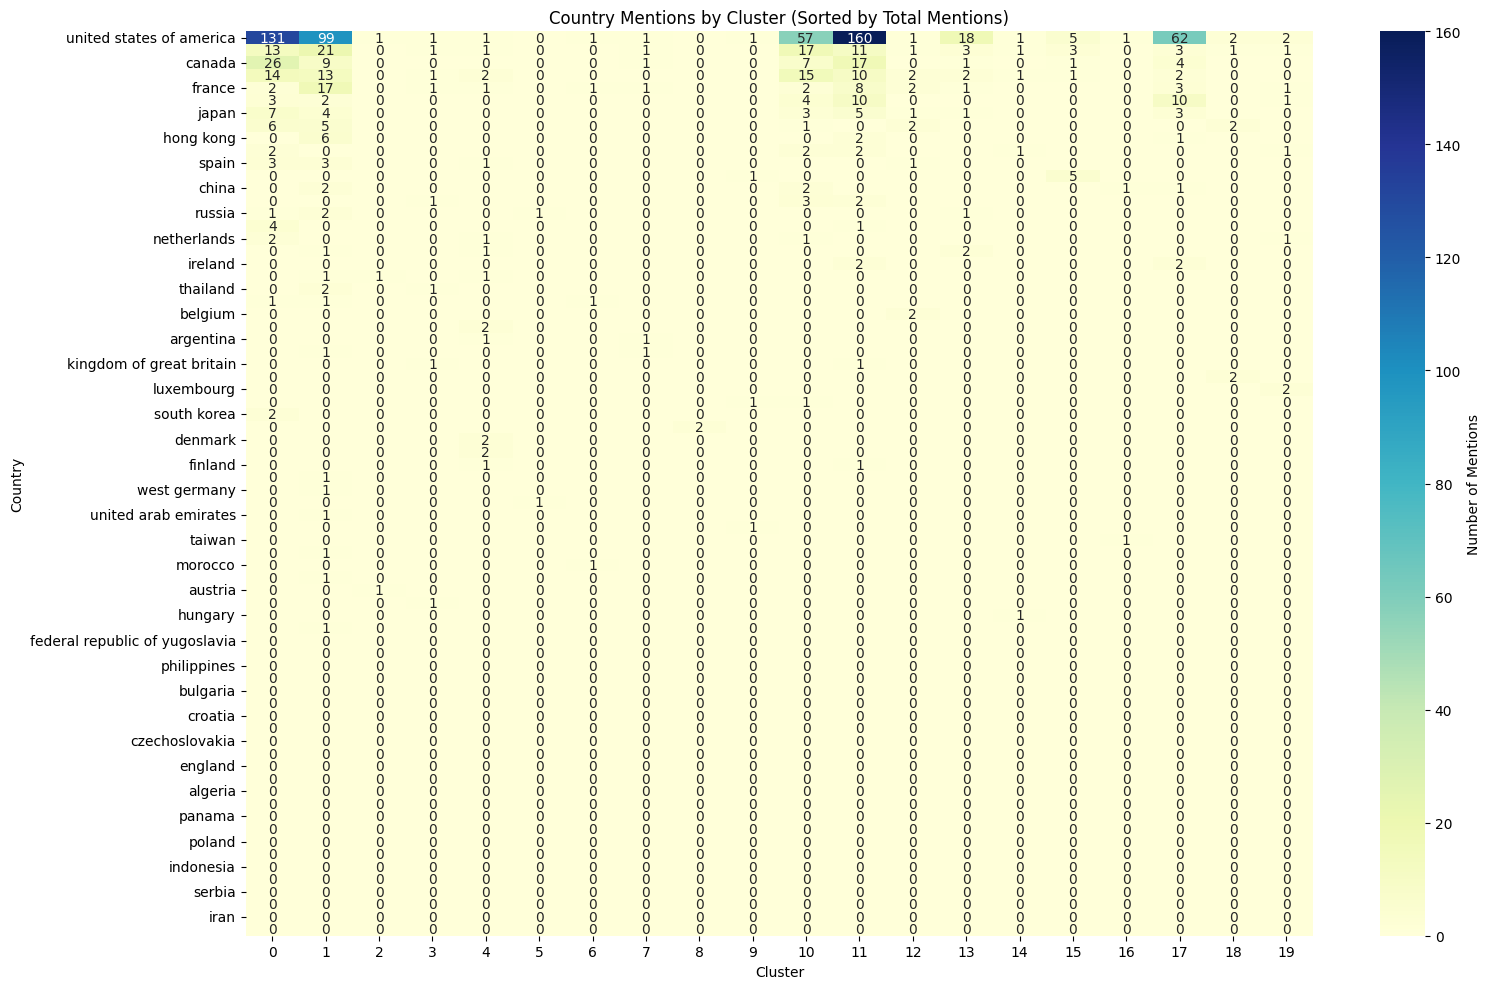

In [15]:
# Summing country mentions by cluster
country_sums = franchise_data_df.groupby('Cluster')[
    [col for col in franchise_data_df.columns if col.startswith('country_')]
].sum()

# Remove the 'country_' prefix from the column names
country_sums.columns = country_sums.columns.str.replace('country_', '')

# Sort countries by total mentions (sum across clusters)
country_sums = country_sums.loc[:, country_sums.sum().sort_values(ascending=False).index]

# Plot the heatmap
plt.figure(figsize=(16, 10))  # Adjust size to fit all countries
sns.heatmap(
    country_sums.T, 
    annot=True, 
    cmap='YlGnBu', 
    fmt='g', 
    cbar_kws={'label': 'Number of Mentions'}
)
plt.title('Country Mentions by Cluster (Sorted by Total Mentions)')
plt.xlabel('Cluster')
plt.ylabel('Country')
plt.tight_layout()
plt.show()


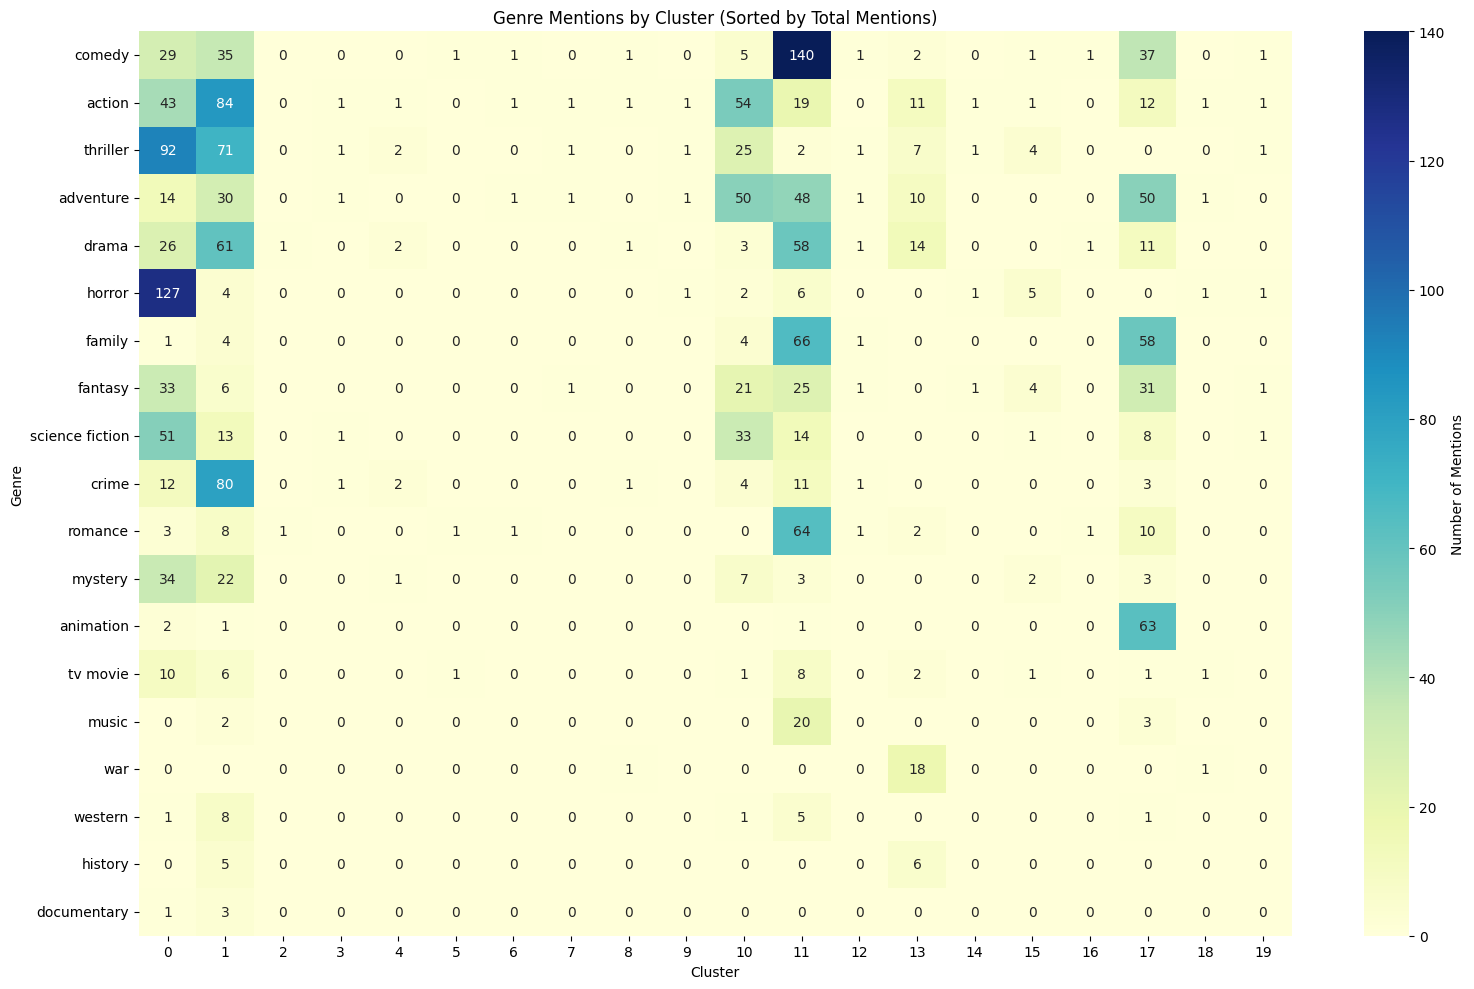

In [16]:
# Summing genre mentions by cluster
genre_sums = franchise_data_df.groupby('Cluster')[
    [col for col in franchise_data_df.columns if col.startswith('genre_')]
].sum()

# Remove the 'genre_' prefix from the column names
genre_sums.columns = genre_sums.columns.str.replace('genre_', '')

# Sort genres by total mentions (sum across clusters)
genre_sums = genre_sums.loc[:, genre_sums.sum().sort_values(ascending=False).index]

# Plot the heatmap
plt.figure(figsize=(16, 10))  # Adjust size to fit all genres
sns.heatmap(
    genre_sums.T, 
    annot=True, 
    cmap='YlGnBu', 
    fmt='g', 
    cbar_kws={'label': 'Number of Mentions'}
)
plt.title('Genre Mentions by Cluster (Sorted by Total Mentions)')
plt.xlabel('Cluster')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()


# Franchise successfulness and pattern investigation

In order to find the underlying pattern in franchises (has a group of movies and not has movies in a franchise), we've used different characteristics of a franchise such has its length, the number of movies in it, the average years between the movies, the average revenue, the average budget, genre that appears in the franchise and country that are link to the franchise.

After trying to find correlation between those different characteristic and having difficulties observing patterns we're going to try a new approach to better understand the franchise dataset.

Since the franchise we have in the dataset can defer a lot from one to another, an idea to go deeper into our analysis is to try to group franchise that have features close to one another. Using the hypothesis that if franchises have features that are similar they would behave the same, then looking at those features we might be able to find interesting pattern.

To group the feature a K nearest neighbors (KNN) was used to the fit the data.

## KNN regression of franchise that have both a average revenue and a average budget

The revenue and budget of a franchise was calculated using the known values of movies in the franchise and was average on the number of movies that had a value. This was done in order to maximize the number of franchise for the analysis, but it can create a bias since its assuming that movies that don't have values must have had a similar revenue and budget.

/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/var/folders/8q/3pfpy7tj5xqdr2spkvvmtngr0000gn/T/ipykernel_22223/4201342542.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



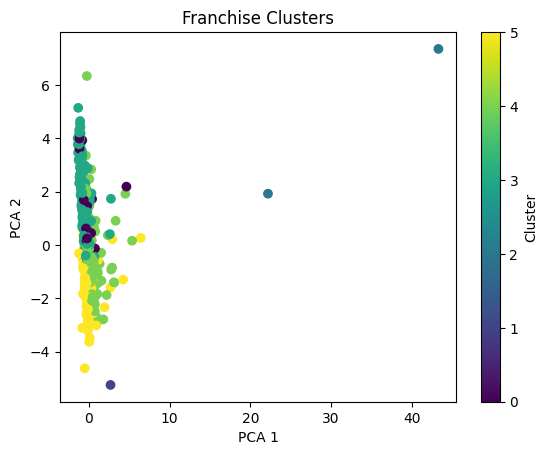

In [145]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd



KNN_data = get_franchise_data(franchise_df)
KNN_data_no_na = KNN_data.dropna(subset=['ratio_rb'])

# genre vecotrization
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(tokenizer=lambda x: x.split(", "))
genre_matrix = vectorizer.fit_transform(KNN_data['genres'])
genre_df = pd.DataFrame(genre_matrix.toarray(), columns=[f'genre_{col}' for col in vectorizer.get_feature_names_out()])
KNN_data = pd.concat([KNN_data, genre_df], axis=1)

vectorizer = CountVectorizer(tokenizer=lambda x: x.split(", "))
country_matrix = vectorizer.fit_transform(KNN_data['country'])
country_df = pd.DataFrame(country_matrix.toarray(), columns=[f'country_{col}' for col in vectorizer.get_feature_names_out()])
KNN_data = pd.concat([KNN_data, country_df], axis=1)

# Separate the franchise with a ratio of revenue over budget and the ones that don't
KNN_data_no_na = KNN_data.dropna(subset=['ratio_rb'])
KNN_data_na = KNN_data[KNN_data['ratio_rb'].isna()]

# Load and preprocess dat
data = KNN_data_no_na.drop(columns=['collection_id','collection_name','genres','oldest_release','newest_release','franchise_length','country','region'])


scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Apply K-Means
kmeans = KMeans(n_clusters=6, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Assign clusters back to franchise_data_df
KNN_data_no_na['Cluster'] = pd.NA  # Initialize Cluster column with NaN
KNN_data_no_na.loc[data.index, 'Cluster'] = clusters

    
# Dimensionality reduction for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis')
plt.title('Franchise Clusters')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.show()

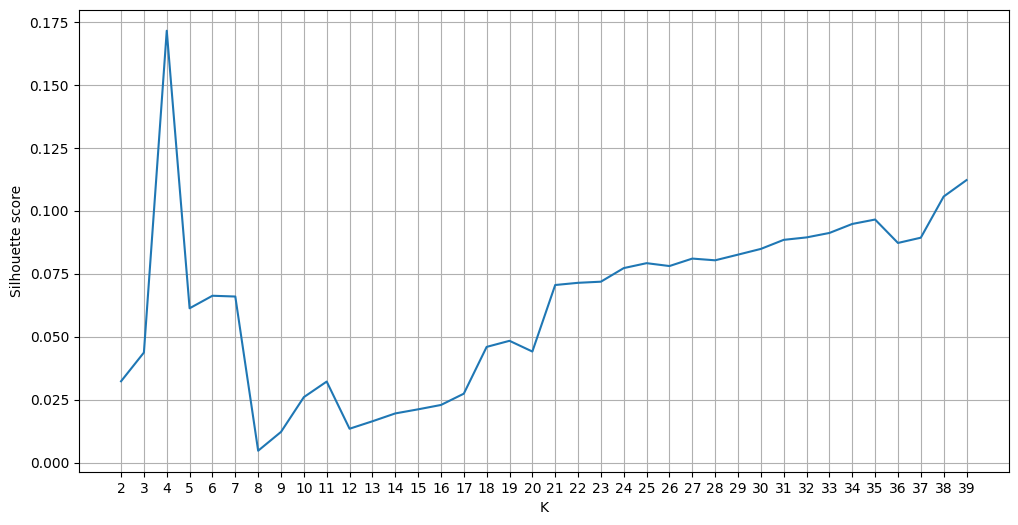

In [18]:
from sklearn.metrics import silhouette_score
silhouettes = []

# Try multiple k
for k in range(2, 40):
    # Cluster the data and assigne the labels
    clusters = KMeans(n_clusters=k, random_state=42,n_init='auto').fit_predict(scaled_data)
    # Get the Silhouette score
    score = silhouette_score(scaled_data, clusters)
    silhouettes.append({"k": k, "score": score})
    
# Convert to dataframe
silhouettes = pd.DataFrame(silhouettes)

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(silhouettes.k, silhouettes.score)
plt.xlabel("K")
plt.ylabel("Silhouette score")
plt.grid()
plt.xticks(range(2, 40))
plt.show()

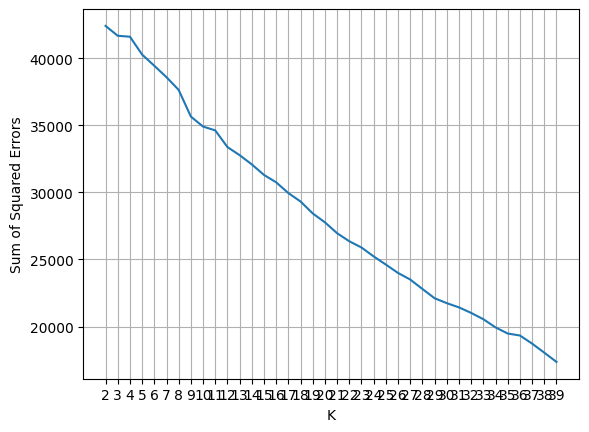

In [19]:
def plot_sse(features_X, start=2, end=40):
    sse = []
    for k in range(start, end):
        # Assign the labels to the clusters
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto').fit(features_X)
        sse.append({"k": k, "sse": kmeans.inertia_})

    sse = pd.DataFrame(sse)
    # Plot the data
    plt.plot(sse.k, sse.sse)
    plt.xlabel("K")
    plt.ylabel("Sum of Squared Errors")
    plt.grid()
    plt.xticks(range(start, end))
    
plot_sse(scaled_data)

## Visualization of what the cluster looks like

Franchise of the cluster of less than 10 movies:
    Cluster                        collection_name
19        1                  James Bond Collection
34        2  USA: Land of Opportunities Collection
150       2              The Millennium Collection


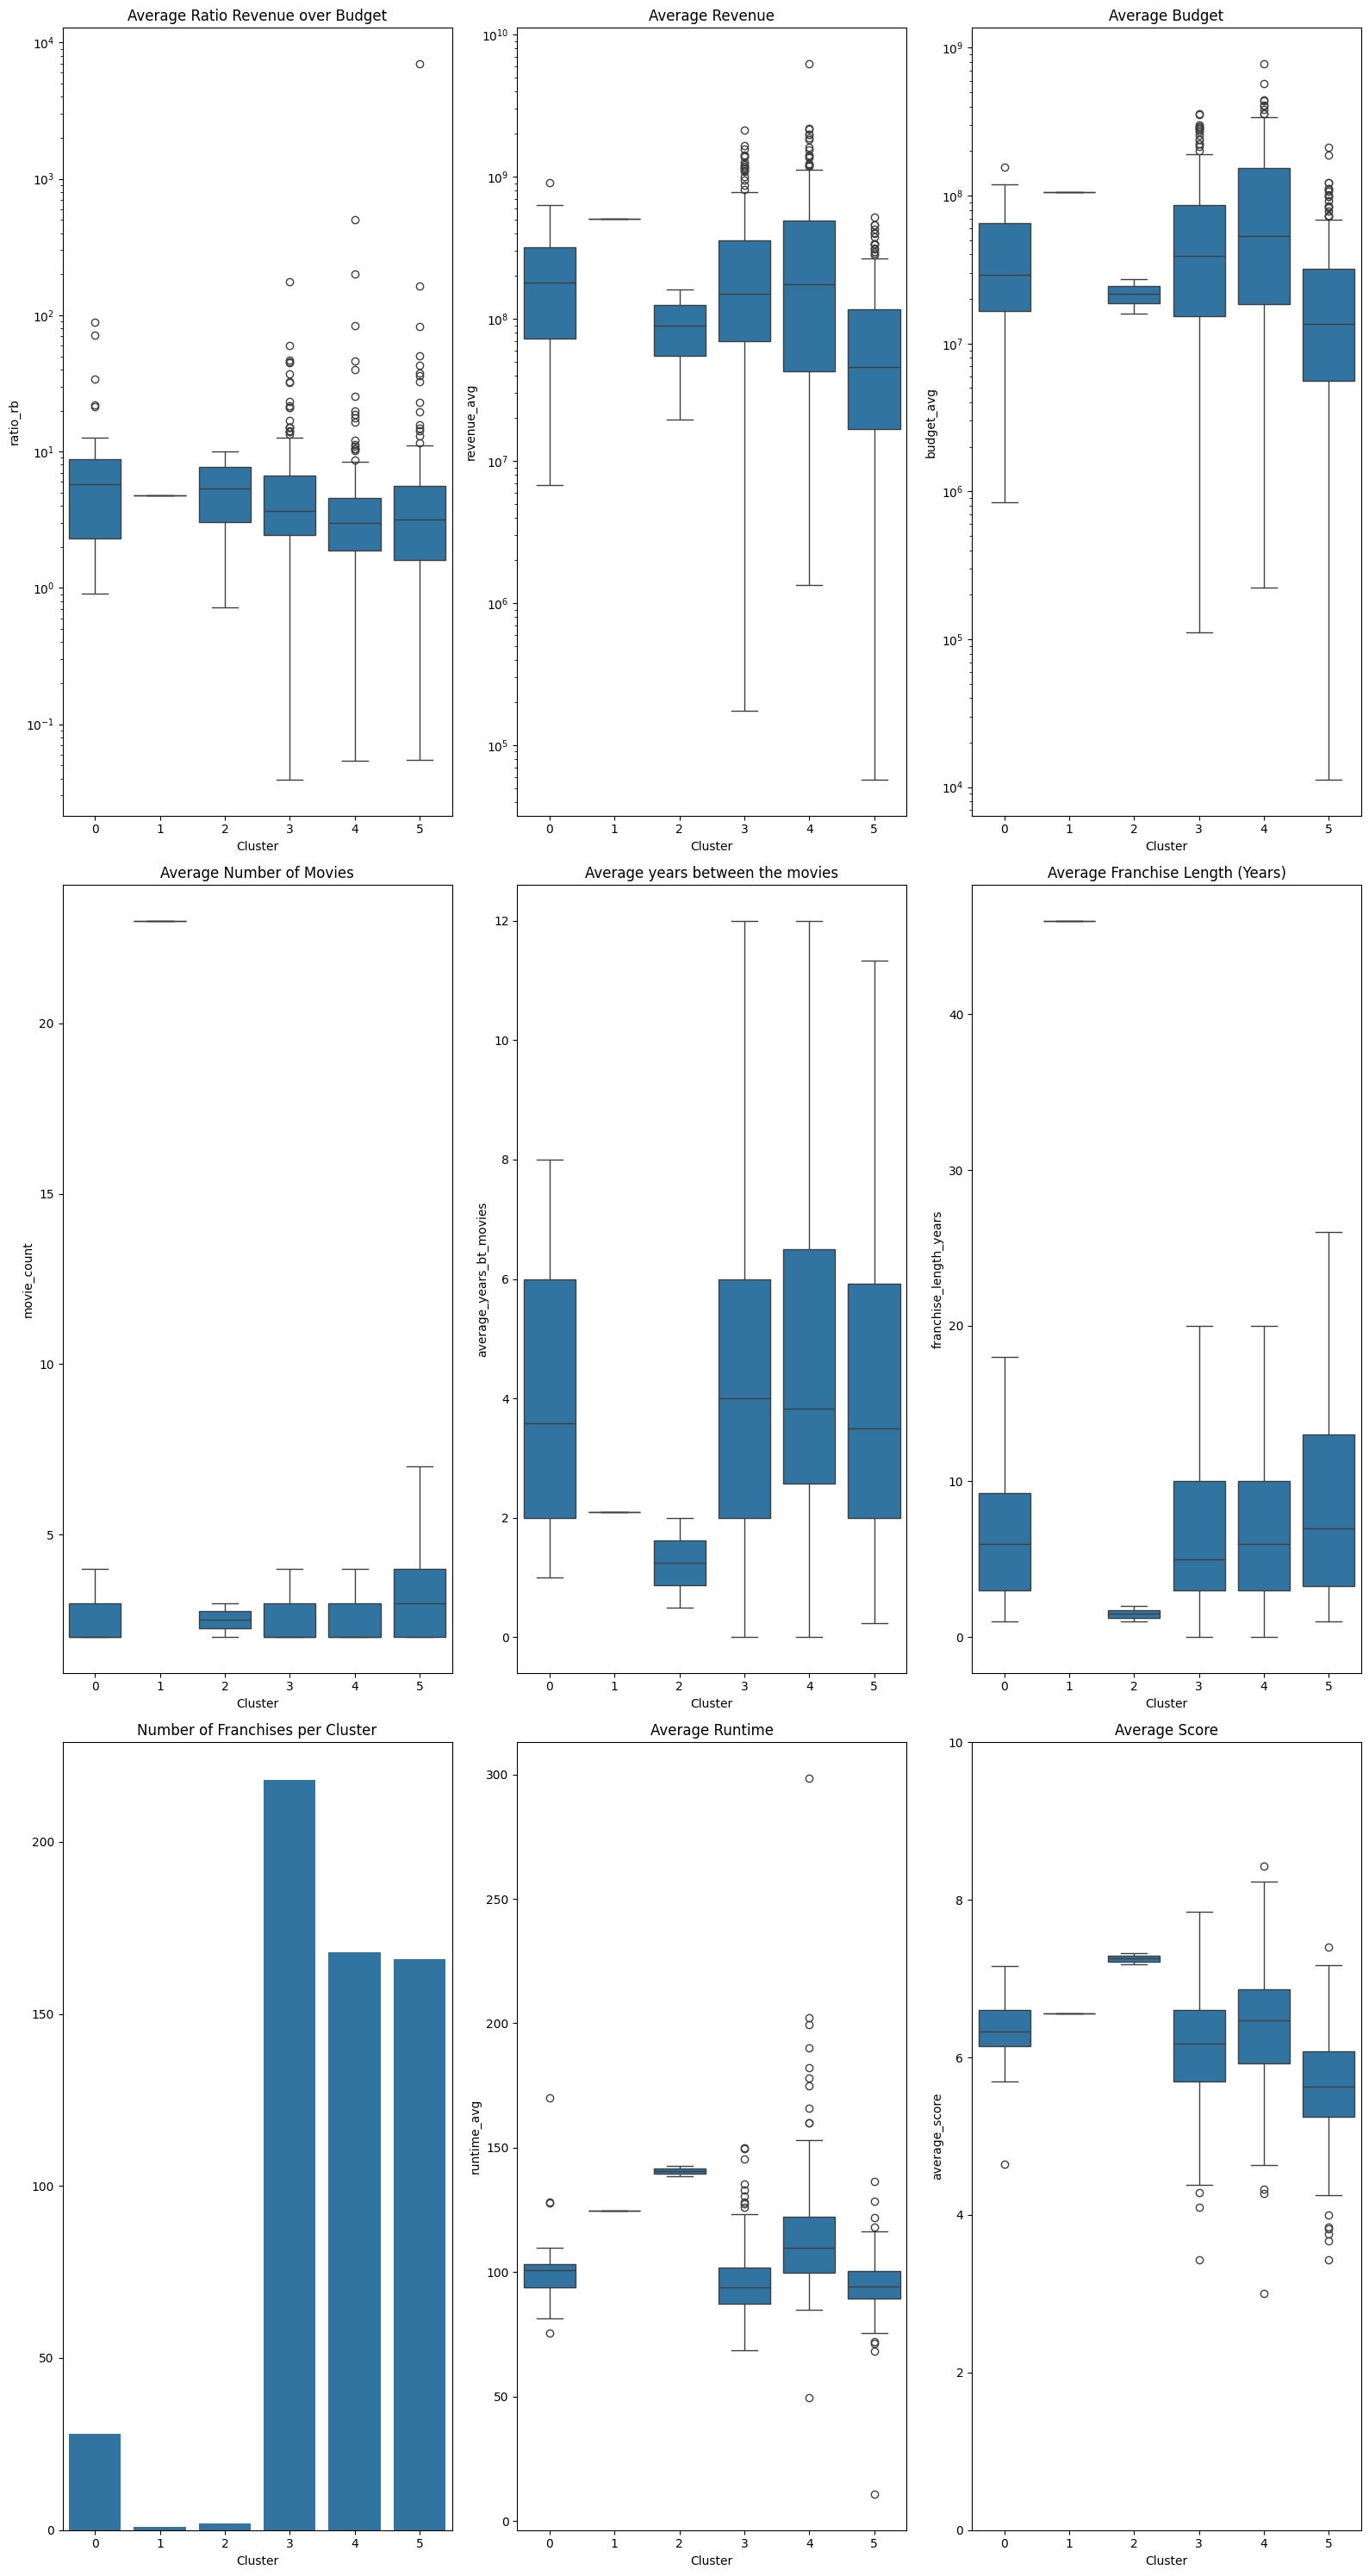

In [160]:
# Drop the cluster with less than 10 franchises idk if it is necessary
KNN_data_filt = KNN_data_no_na.groupby('Cluster').filter(lambda x: len(x) >= 0)




# Print the small cluster
print("Franchise of the cluster of less than 10 movies:")
print(KNN_data_no_na[~KNN_data_no_na['Cluster'].isin(KNN_data_no_na.groupby('Cluster').filter(lambda x: len(x) >= 10)['Cluster'])][['Cluster','collection_name']].sort_values(by='Cluster'))


fig, axs = plt.subplots(3, 3, figsize=(16, 30))

# # Detect outliers (using IQR for demonstration)
# def detect_outliers(group):
#     q1 = group.quantile(0.25)
#     q3 = group.quantile(0.75)
#     iqr = q3 - q1
#     lower_bound = q1 - 1.5 * iqr
#     upper_bound = q3 + 1.5 * iqr
#     return group[(group < lower_bound) | (group > upper_bound)]

# KNN_data_filt['Outlier_ratio_rb'] = KNN_data_filt.groupby('Cluster')['ratio_rb'].transform(lambda x: detect_outliers(x))

# # Barplot
# without_outliers = KNN_data_filt[KNN_data_filt['Outlier_ratio_rb'].isna()]
# sns.barplot(data=without_outliers, x='Cluster', y='ratio_rb', ax=axs[0,0])

# # Overlay outliers
# outliers = KNN_data_filt[KNN_data_filt['Outlier_ratio_rb'].notna()]
# outliers['Cluster'] = outliers['Cluster'].replace({1:0, 2:1, 3:2, 4:3})

# sns.scatterplot(data=outliers, x='Cluster', y='ratio_rb', color='red', s=100, label='Outliers', alpha=.25, ax=axs[0,0])


sns.boxplot(x='Cluster', y='ratio_rb', data=KNN_data_filt, ax=axs[0,0])
axs[0,0].set_title('Average Ratio Revenue over Budget')
axs[0,0].set_yscale('log')
sns.boxplot(x='Cluster', y='revenue_avg', data=KNN_data_filt, ax=axs[0,1])
axs[0,1].set_title('Average Revenue')
axs[0,1].set_yscale('log')

sns.boxplot(x='Cluster', y='budget_avg', data=KNN_data_filt, ax=axs[0,2])
axs[0,2].set_title('Average Budget')
axs[0,2].set_yscale('log')

sns.boxplot(x='Cluster', y='movie_count', data=KNN_data_filt,showfliers=False, ax=axs[1,0])
axs[1,0].set_title('Average Number of Movies')
sns.boxplot(x='Cluster', y='average_years_bt_movies', data=KNN_data_filt,showfliers=False, ax=axs[1,1])
axs[1,1].set_title('Average years between the movies')


sns.boxplot(x='Cluster', y='franchise_length_years', data=KNN_data_filt,showfliers=False, ax=axs[1,2])
axs[1,2].set_title('Average Franchise Length (Years)')
sns.barplot(x=KNN_data_no_na['Cluster'].value_counts().index, y=KNN_data_no_na['Cluster'].value_counts().values, ax=axs[2,0])
axs[2,0].set_title('Number of Franchises per Cluster')
sns.boxplot(x='Cluster', y='runtime_avg', data=KNN_data_filt, ax=axs[2,1])
axs[2,1].set_title('Average Runtime')
sns.boxplot(x='Cluster', y='average_score', data=KNN_data_filt, ax=axs[2,2])
axs[2,2].set_title('Average Score')
axs[2,2].set_ylim(0, 10)

plt.tight_layout()
plt.show()



By doing different number of cluster we quickly observe that it can pretty easily make 4 clusters with a lot of franchises, the James Bonds' franchise is always alone and there are some other outliers that varies slightly when the number of cluster is increase, but 6 clusters made interesting results, so we're going to stick with that. 

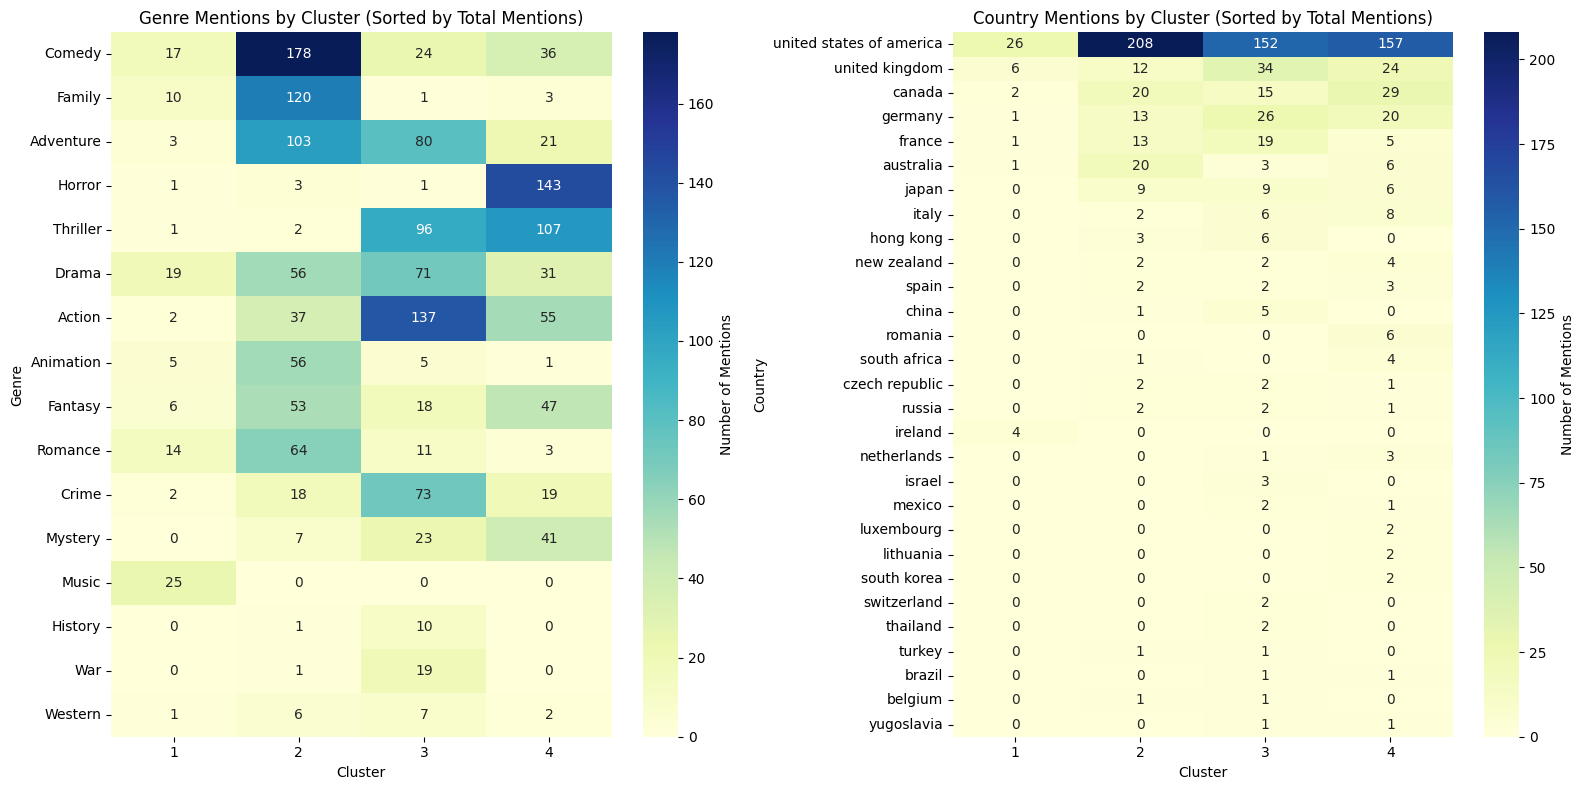

In [72]:
# Summing country mentions by cluster
country_sums = KNN_data_filt.groupby('Cluster')[
    [col for col in KNN_data_filt.columns if col.startswith('country_')]
].sum()

# Remove the 'country_' prefix from the column names
country_sums.columns = country_sums.columns.str.replace('country_', '')

# Sort countries by total mentions (sum across clusters)
country_sums = country_sums.loc[:, country_sums.sum().sort_values(ascending=False).index]
# remove the country that are mentionned only once
country_sums = country_sums.loc[:, country_sums.sum() > 1]


# Summing genre mentions by cluster
genre_sums = KNN_data_filt.groupby('Cluster')[
    [col for col in KNN_data_filt.columns if col.startswith('genre_')]
].sum()

# Remove the 'genre_' prefix from the column names
genre_sums.columns = genre_sums.columns.str.replace('genre_', '')

# put a capital letter at the beginning of the genre
genre_sums.columns = genre_sums.columns.str.capitalize()

# manually sorting the row to make the heatmap more readable
genre_sums = genre_sums.loc[:, ['Comedy', 'Family', 'Adventure', 'Horror', 'Thriller', 'Drama', 'Action', 'Animation', 'Fantasy', 'Romance', 'Crime', 'Mystery', 'Music', 'History', 'War', 'Western']]



# Plot the heatmap
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
sns.heatmap(
    genre_sums.T, 
    annot=True, 
    cmap='YlGnBu', 
    fmt='g', 
    cbar_kws={'label': 'Number of Mentions'},
    ax=axs[0]
)
axs[0].set_title('Genre Mentions by Cluster (Sorted by Total Mentions)')
axs[0].set_xlabel('Cluster')
axs[0].set_ylabel('Genre')

sns.heatmap(
    country_sums.T, 
    annot=True, 
    cmap='YlGnBu', 
    fmt='g', 
    cbar_kws={'label': 'Number of Mentions'},
    ax=axs[1]
)
axs[1].set_title('Country Mentions by Cluster (Sorted by Total Mentions)')
axs[1].set_xlabel('Cluster')
axs[1].set_ylabel('Country')
plt.tight_layout()
plt.show()



In [22]:
import base64
from IPython.display import display, HTML
import os
import json
import plotly.graph_objects as go
import plotly.io as pio

import numpy as np
import pandas as pd

### Imports the font in your current notebook

current_dir = os.getcwd()
font_path = os.path.join(current_dir, "src/utils/JetBrainsMono-Regular.otf")

# Read and encode the font file
with open(font_path, "rb") as font_file:
    encoded_font = base64.b64encode(font_file.read()).decode()

font_css = f"""
<style>
@font-face {{
    font-family: 'JetBrains Mono';
    src: url(data:font/otf;base64,{encoded_font});
}}
</style>
"""
display(HTML(font_css))


### Color palette
yellow_palette=["#FFEE00","#D5C923","#AAA239","#807B40","#555339","#33322B"] # goes from bright yellow to dark yellow

In [158]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import pandas as pd
import numpy as np

# Filter clusters and remap them
KNN_data_filt = KNN_data_no_na.groupby('Cluster').filter(lambda x: len(x) >= 10)
KNN_data_filt['Cluster'] = KNN_data_filt['Cluster'].replace({0: 1, 3: 2, 4: 3, 5: 4})



# Create outliers dataframes for each column of interest
outliers_ratio_rb = KNN_data_no_na[(KNN_data_no_na['Cluster'] == 1) | (KNN_data_no_na['Cluster'] == 2)][['Cluster', 'ratio_rb','collection_name']]
outliers_revenue_avg = KNN_data_no_na[(KNN_data_no_na['Cluster'] == 1) | (KNN_data_no_na['Cluster'] == 2)][['Cluster', 'revenue_avg','collection_name']]
outliers_budget_avg = KNN_data_no_na[(KNN_data_no_na['Cluster'] == 1) | (KNN_data_no_na['Cluster'] == 2)][['Cluster', 'budget_avg','collection_name']]

# Create a subplot layout with 1 row and 4 columns
fig = make_subplots(
    rows=1, cols=4, 
    subplot_titles=[
        'Average Ratio<br>Revenue/Budget', 
        'Average<br>Revenue', 
        'Average<br>Budget',
        'Genre Mentions<br>by Cluster'  # Moved heatmap title to position 4
    ],
    column_widths=[0.25, 0.25, 0.25, 0.25],
    horizontal_spacing=0.13  # Adjusted horizontal spacing
)

# Adjust subplot titles for left alignment
fig.update_layout(
    title_x=0.05,  # Move title to the left
    title_xanchor='left',  # Align title to the left side of the graph
)

# Create hover text for outliers
hover_text = [f"Collection: {name}" for name in KNN_data_filt['collection_name']]

# Add the box plot for 'ratio_rb'
fig.add_trace(
    go.Box(
        x=KNN_data_filt['Cluster'],
        y=KNN_data_filt['ratio_rb'],
        boxpoints='outliers',
        marker_color='orange',
        text=hover_text,
        hoverinfo="x+y+text",
        name='Ratio RB'
    ),
    row=1, col=1
)

# Add scatter plot for outliers on 'ratio_rb'
fig.add_trace(
    go.Scatter(
        x=[1.5 , 2.5, 3.5],
        y=outliers_ratio_rb['ratio_rb'],
        mode='markers',
        marker=dict(color='red', size=8),
        name='Outliers - Ratio RB',
        text=outliers_ratio_rb['collection_name'],
        hoverinfo="text+y"
    ),
    row=1, col=1
)

# Add the box plot for 'revenue_avg'
fig.add_trace(
    go.Box(
        x=KNN_data_filt['Cluster'],
        y=KNN_data_filt['revenue_avg'],
        boxpoints='outliers',
        marker_color='green',
        text=hover_text,
        hoverinfo="x+y+text",
        name='Revenue'
    ),
    row=1, col=2
)

# Add scatter plot for outliers on 'revenue_avg'
fig.add_trace(
    go.Scatter(
        x=[1.5 , 2.5, 3.5],
        y=outliers_revenue_avg['revenue_avg'],
        mode='markers',
        marker=dict(color='red', size=8),
        name='Outliers - Revenue',
        text=outliers_revenue_avg['collection_name'],
        hoverinfo="text+y"
    ),
    row=1, col=2
)

# Add the box plot for 'budget_avg'
fig.add_trace(
    go.Box(
        x=KNN_data_filt['Cluster'],
        y=KNN_data_filt['budget_avg'],
        boxpoints='outliers',
        marker_color='blue',
        text=hover_text,
        hoverinfo="x+y+text",
        name='Budget'
    ),
    row=1, col=3
)

# Add scatter plot for outliers on 'budget_avg'
fig.add_trace(
    go.Scatter(
        x=[1.5 , 2.5, 3.5],
        y=outliers_budget_avg['budget_avg'],
        mode='markers',
        marker=dict(color='red', size=8),
        name='Outliers - Budget',
        text=outliers_budget_avg['collection_name'],
        hoverinfo="text+y"
    ),
    row=1, col=3
)

# Add the heatmap (moved to position 4)
fig.add_trace(
    go.Heatmap(
        z=genre_sums.T.values[::-1],
        x=genre_sums.index,   # Cluster names
        y=genre_sums.T.index[::-1],  # Genre names, reversed order
        colorscale='YlGnBu',
        hovertemplate='Genre: %{y}<br>Cluster: %{x}<br>Mentions: %{z}<extra></extra>',
        colorbar=dict(
            title='Mentions',
            tickvals=[10, 30, 50,70,90,110,130,150,170],  # Example tick values
            ticktext=['10', '30', '50', '70', '90', '110', '130', '150', '170'],  # Example tick text
            len=0.75,  # Adjust the length of the colorbar
            x=1.05,    # Move the colorbar to the right
            y=0.5,     # Center the colorbar vertically
            yanchor='middle',  # Ensures the colorbar is centered vertically
        )
    ),
    row=1, col=4
)

# Update axes
fig.update_xaxes(title_text='Cluster', row=1, col=1, title_standoff=10)
fig.update_xaxes(title_text='Cluster', row=1, col=2, title_standoff=10)
fig.update_xaxes(title_text='Cluster', row=1, col=3, title_standoff=10)
fig.update_xaxes(title_text='Cluster', row=1, col=4, title_standoff=10)

fig.update_yaxes(title_text='Genres', row=1, col=4, title_standoff=10)  # Adjust y-axis title for heatmap
fig.update_yaxes(title_text='Ratio Revenue/Budget', row=1, col=1, type='log', title_standoff=10)
fig.update_yaxes(title_text='Revenue', row=1, col=2, type='log', title_standoff=10)
fig.update_yaxes(title_text='Budget', row=1, col=3, type='log', title_standoff=10)

# Update layout for aesthetics, grid lines, and tight fit
fig.update_layout(
    font=dict(family="JetBrains Mono", size=10, color="black"),  # Reduced font size
    height=600,  # Height of the plot
    width=1000,  # Increased width to 1000px for better spacing
    margin=dict(t=50, l=100, r=50, b=50),  # Increased right margin for better spacing
    plot_bgcolor='rgba(0,0,0,0)',  # Transparent plot background
    paper_bgcolor='rgba(0,0,0,0)',  # Transparent paper background
    showlegend=True,
        legend=dict(
        x=1.05,  # Place the legend just outside the plot on the right
        y=1,   # Center the legend vertically
        xanchor='left',  # Align the legend to the left side of its container
        yanchor='middle',  # Center the legend vertically
        orientation='v',  # Set legend orientation to vertical
        traceorder='normal',  # Ensure traces are ordered normally
        itemclick='toggle',  # Allow users to toggle traces on and off by clicking
        itemdoubleclick='toggleothers'  # Double-click to hide all other traces
    ),
    )

# Show the figure
fig.show()


/var/folders/8q/3pfpy7tj5xqdr2spkvvmtngr0000gn/T/ipykernel_22223/2805364130.py:8: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [159]:
##---TO MODIFY---##
website_dir = "/Users/pierre/Documents/EPFL masteroche/ADA/ada-website.github.io" ### Change to your 'ada_website' directory

graph_name = "franchise_clusters" ### Assign graph name
##---------------##

graph_json_path = website_dir + "/_includes/graphs/" + graph_name + ".json"
graph_html_path = website_dir + "/_includes/graphs/" + graph_name + ".html"

# Save the graph as JSON (this only includes the data and layout)
pio.write_json(fig, graph_json_path)

with open(graph_json_path, 'r') as json_file:
    graph_data = json.load(json_file)

# Create the minimal HTML structure with Plotly CDN
html_content = f"""
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
    <title>{graph_name} Graph</title>
</head>
<body>
    <div id="{graph_name}" class="graph" style="width: 100%; height: 100%;"></div>
    <script>
        var graphData = {json.dumps(graph_data)};
        Plotly.newPlot('{graph_name}', graphData.data, graphData.layout);
    </script>
</body>
</html>
"""

# Write the content to the HTML file
with open(graph_html_path, 'w') as html_file:
    html_file.write(html_content)


In [24]:

# Create the heatmap
fig = go.Figure(
    data=go.Heatmap(
        z=genre_sums.T.values,  # Data values for the heatmap
        x=genre_sums.index,   # Cluster names
        y=genre_sums.T.index,   # Genre names
        colorscale='YlGnBu',    # Color scheme
        text=genre_sums.T.values,  # Add annotations
        hovertemplate='Genre: %{y}<br>Cluster: %{x}<br>Mentions: %{z}<extra></extra>',
        colorbar=dict(title='Number of Mentions')  # Label for the color bar
    )
)

# Update layout for titles and axis labels
fig.update_layout(
    title='Genre Mentions by Cluster',
    xaxis_title='Cluster',
    yaxis_title='Genre',
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False),
    height=600,
    width=800
)
fig.update_layout(
    showlegend=False,
    font=dict(
        size=10,
        family="JetBrains Mono",
        color="black",
    ),
    legend=dict(
        font=dict(size=10),
        xanchor='left',
        x=0.80,
        yanchor='top',
        y=0.8,
    ),
    paper_bgcolor='rgba(0,0,0,0)', # to make the background transparent
    plot_bgcolor='rgba(0,0,0,0)'
)
# Show the figure
fig.show()


### Summary by cluster

Cluster 1:

In [25]:
KNN_data_no_na[KNN_data_no_na['Cluster']==0]['collection_name']

75                      Bridget Jones Collection
77                      Wayne's World Collection
138              The Land Before Time Collection
220                          Fantasia Collection
256                     Dirty Dancing Collection
258                            Grease Collection
259                           Step Up Collection
296               High School Musical Collection
330                          Breakin' Collection
399                        Sister Act Collection
421               Save the Last Dance Collection
446                The Blues Brothers Collection
569             All Dogs Go to Heaven Collection
590                             Honey Collection
625                    Stomp the Yard Collection
642           Alvin and the Chipmunks Collection
736                       StreetDance Collection
784                        Billy Jack Collection
793                      Center Stage Collection
853                       Tony Manero Collection
880                 

This cluster is the cluster of the musical, mostly produces by the United States, they have a pretty good ratio of budget over revenues, and they never have more that 3-4 movies.

Cluster 2:

In [26]:
KNN_data_no_na[KNN_data_no_na['Cluster']==1]['collection_name']

19    James Bond Collection
Name: collection_name, dtype: object

The second cluster is the James Bond one, it is a big outlier that was already noticed previously and confirm again. It looks like no other franchise can be compared to it. It is around 25 movies that have been produced in 45 years, so around a movie each 2 years, and it has an average revenue that is big compared to other franchise. I think what makes this franchise unique is that its timeless.

Cluster 3:

In [27]:
KNN_data_no_na[KNN_data_no_na['Cluster']==2]['collection_name']

34     USA: Land of Opportunities Collection
150                The Millennium Collection
Name: collection_name, dtype: object

This is the other cluster with outliers, I personally never heard of those movies, but it looks like it got excellent review on tmbd and the movie runtime is longer than average. We also observe that one of those two franchise must have not really work out in the end since a ratio of revenue over budget is pretty low.

Cluster 4:

In [28]:
pd.set_option('display.max_rows', 500)  # Set a higher row limit
KNN_data_filt[KNN_data_filt['Cluster'] == 3]['collection_name']

0                             Star Wars Collection
1                         Indiana Jones Collection
2                 The Lord of the Rings Collection
4        Star Trek: The Original Series Collection
5                         The Godfather Collection
6                       The Dark Knight Collection
8              Pirates of the Caribbean Collection
9                               Ocean's Collection
10                        Jurassic Park Collection
11                             Predator Collection
16                       The Terminator Collection
18                           Spider-Man Collection
22                                X-Men Collection
24                        Lethal Weapon Collection
26                         Harry Potter Collection
28                             Die Hard Collection
29                                Rocky Collection
31                                Zorro Collection
32        Planet of the Apes (Original) Collection
33                            T

This is one of the first really big cluster, it looks like its mostly teenage movies, animated movies, disneys and family sitcom. The main genre is comedy and 

Cluster 5:

In [29]:
KNN_data_filt[KNN_data_filt['Cluster'] == 4]['collection_name']

13                                 Cube Collection
20                                  Saw Collection
21                                Blade Collection
23          The Pink Panther (Original) Collection
27                  28 Days/Weeks Later Collection
35                            Evil Dead Collection
37                           The Grudge Collection
40                           Underworld Collection
42                                 Jaws Collection
45                               Scream Collection
51                     World of Watches Collection
54      I Know What You Did Last Summer Collection
61                           Highlander Collection
62                                Alien Collection
67            A Nightmare on Elm Street Collection
72                    Final Destination Collection
73                           Hellraiser Collection
74         The Hills Have Eyes (Reboot) Collection
79                         The Prophecy Collection
85                 An American 

This cluster looks like its mostly action movies and blockbuster hence it is also the pretty high budget franchise.

cluster 6:

In [30]:
KNN_data_filt[(KNN_data_filt['Cluster'] == 5) & (KNN_data_filt['ratio_rb'] > 20)][['collection_name','ratio_rb']]

,collection_name,ratio_rb


This cluster is the clusters of the horror and thrillers movies, we can see that it has most of the time smaller budget but can have a ratio that can be really high depending on the franchise.

To conclude this part it looks like the pattern we were looking for is kind of hard to define, it looks like the cluster have mostly been separated by their genre which looks like its link to the average budget of the franchise. We were thinking that the successfulness of a franchise could be seen in the ratio of the revenue over the budget, but the results don't give a clear answer. There must still be features of franchise that would define better their successfulness, but we don't have them, that's why there's a big variance in the ratios.

It also looks like analyzing the franchise has a whole makes it difficult to quantify what is going to make a good franchise because the success inside a franchise can vary a lot that's why in the next part we're going to look at the interaction between the first a second and how from a first movie that work pretty well make another successful movie or a successful franchise,

## KNN regression of the first and second movie of the franchise (that both have values for budget and revenue)

In this part we're going to try to look more specificly on how does the first and second movie interact and which common behaviour of the first movie impacts the second movie.

After some trial and errors, the KNN couldn't really separate the franchise where the 2nd movie performs better than the first one, so to make it more relevant for our analysis 

/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



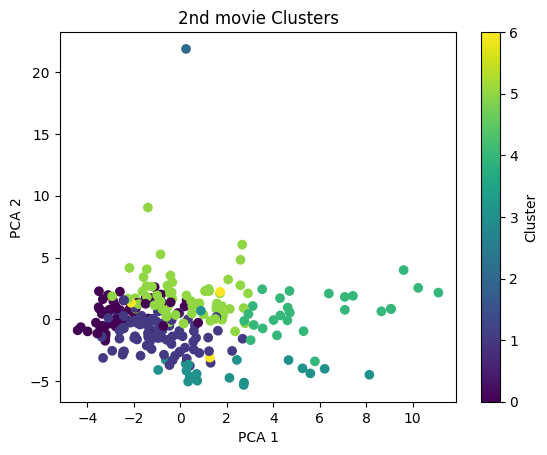

In [31]:
KNN_1_2 = get_1_2_movies(franchise_df)
KNN_1_2 = KNN_1_2.dropna(subset=['real_profit_1'])
KNN_1_2 = KNN_1_2.dropna(subset=['real_profit_2'])

# seprate the franchise where the 2nd movie has a higher ratio than the first one
KNN_1_2_2ndbetter=KNN_1_2[KNN_1_2['ratio_revenue_budget_2'] > KNN_1_2['ratio_revenue_budget_1']]
KNN_1_2_other=KNN_1_2[KNN_1_2['ratio_revenue_budget_2'] <= KNN_1_2['ratio_revenue_budget_1']]

# Load and preprocess dat
#data = KNN_1_2_other.drop(columns=['collection_id','Wikipedia movie ID_1','Wikipedia movie ID_2','Movie name_1','Movie name_2','collection_name_1','collection_name_2','genres_1','genres_2','tmdb_origin_country_1','tmdb_origin_country_2'])

data = KNN_1_2.drop(columns=['collection_id','Wikipedia movie ID_1','Wikipedia movie ID_2','Movie name_1','Movie name_2','collection_name_1','collection_name_2','genres_1','genres_2','tmdb_origin_country_1','tmdb_origin_country_2'])

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Apply K-Means
kmeans = KMeans(n_clusters=7, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Assign clusters back to franchise_data_df
KNN_1_2['Cluster'] = pd.NA  # Initialize Cluster column with NaN
KNN_1_2.loc[data.index, 'Cluster'] = clusters
    
# Dimensionality reduction for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis')
plt.title('2nd movie Clusters')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.show()

# # Load and preprocess dat
# data = KNN_1_2_2ndbetter.drop(columns=['collection_id','Wikipedia movie ID_1','Wikipedia movie ID_2','Movie name_1','Movie name_2','collection_name_1','collection_name_2','genres_1','genres_2','tmdb_origin_country_1','tmdb_origin_country_2'])
#data = KNN_1_2.drop(columns=['collection_id','Wikipedia movie ID_1','Wikipedia movie ID_2','Movie name_1','Movie name_2','collection_name_1','collection_name_2','genres_1','genres_2','tmdb_origin_country_1','tmdb_origin_country_2'])


# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(data)

# # Apply K-Means
# kmeans = KMeans(n_clusters=3, random_state=42)
# clusters = kmeans.fit_predict(scaled_data)

# # Assign clusters back to franchise_data_df
# KNN_1_2.loc[data.index, 'Cluster'] = -clusters-1
    
# # Dimensionality reduction for visualization
# pca = PCA(n_components=2)
# reduced_data = pca.fit_transform(scaled_data)
# plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis')
# plt.title('2nd movie Clusters')
# plt.xlabel('PCA 1')
# plt.ylabel('PCA 2')
# plt.colorbar(label='Cluster')
# plt.show()


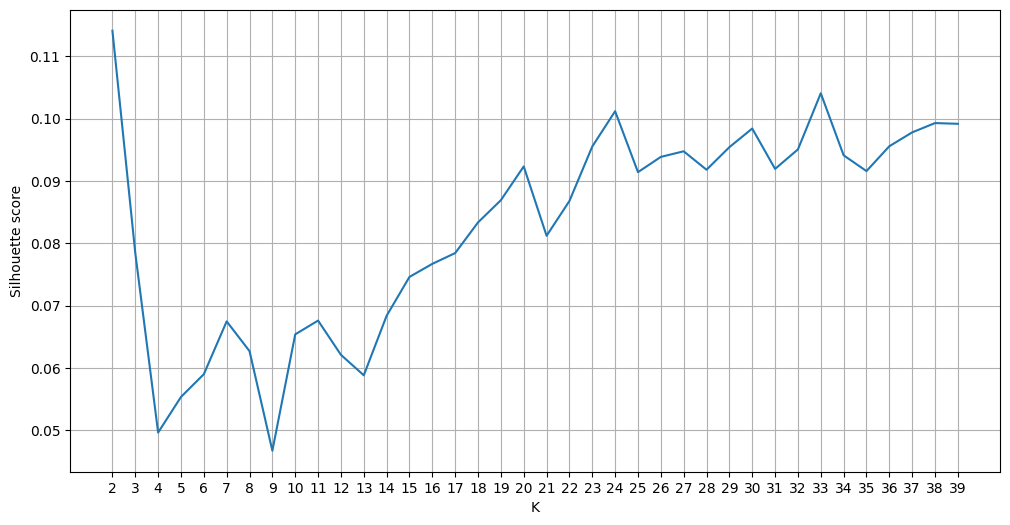

In [32]:
from sklearn.metrics import silhouette_score
silhouettes = []

# Try multiple k
for k in range(2, 40):
    # Cluster the data and assigne the labels
    clusters = KMeans(n_clusters=k, random_state=42,n_init='auto').fit_predict(scaled_data)
    # Get the Silhouette score
    score = silhouette_score(scaled_data, clusters)
    silhouettes.append({"k": k, "score": score})
    
# Convert to dataframe
silhouettes = pd.DataFrame(silhouettes)

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(silhouettes.k, silhouettes.score)
plt.xlabel("K")
plt.ylabel("Silhouette score")
plt.grid()
plt.xticks(range(2, 40))
plt.show()

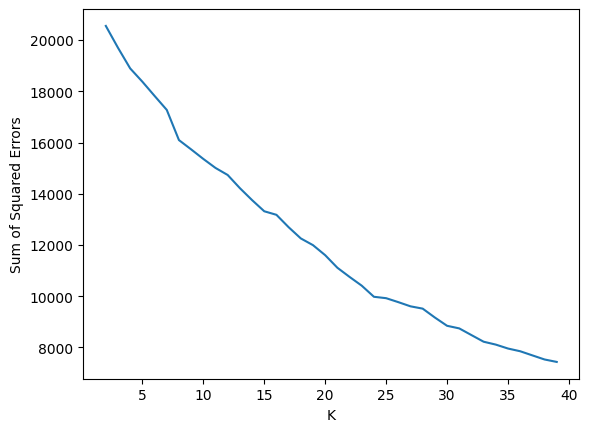

In [33]:
def plot_sse(features_X, start=2, end=40):
    sse = []
    for k in range(start, end):
        # Assign the labels to the clusters
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto').fit(features_X)
        sse.append({"k": k, "sse": kmeans.inertia_})

    sse = pd.DataFrame(sse)
    # Plot the data
    plt.plot(sse.k, sse.sse)
    plt.xlabel("K")
    plt.ylabel("Sum of Squared Errors")
    
plot_sse(scaled_data)

## Visualization of what the cluster looks like

Franchise of the cluster of less than 10 movies:
    Cluster                     collection_name_1  \
150       2             The Millennium Collection   
245       6  Arthur and the Invisibles Collection   
548       6                      Taken Collection   
782       6             Spanish Apartment Trilogy   

                        Movie name_1                           Movie name_2  
150  The Girl with the Dragon Tattoo          The Girl Who Played with Fire  
245        Arthur and the Invisibles  Arthur and the Vengeance of Maltazard  
548                            Taken                                Taken 2  
782                         Pot Luck                      The Russian Dolls  


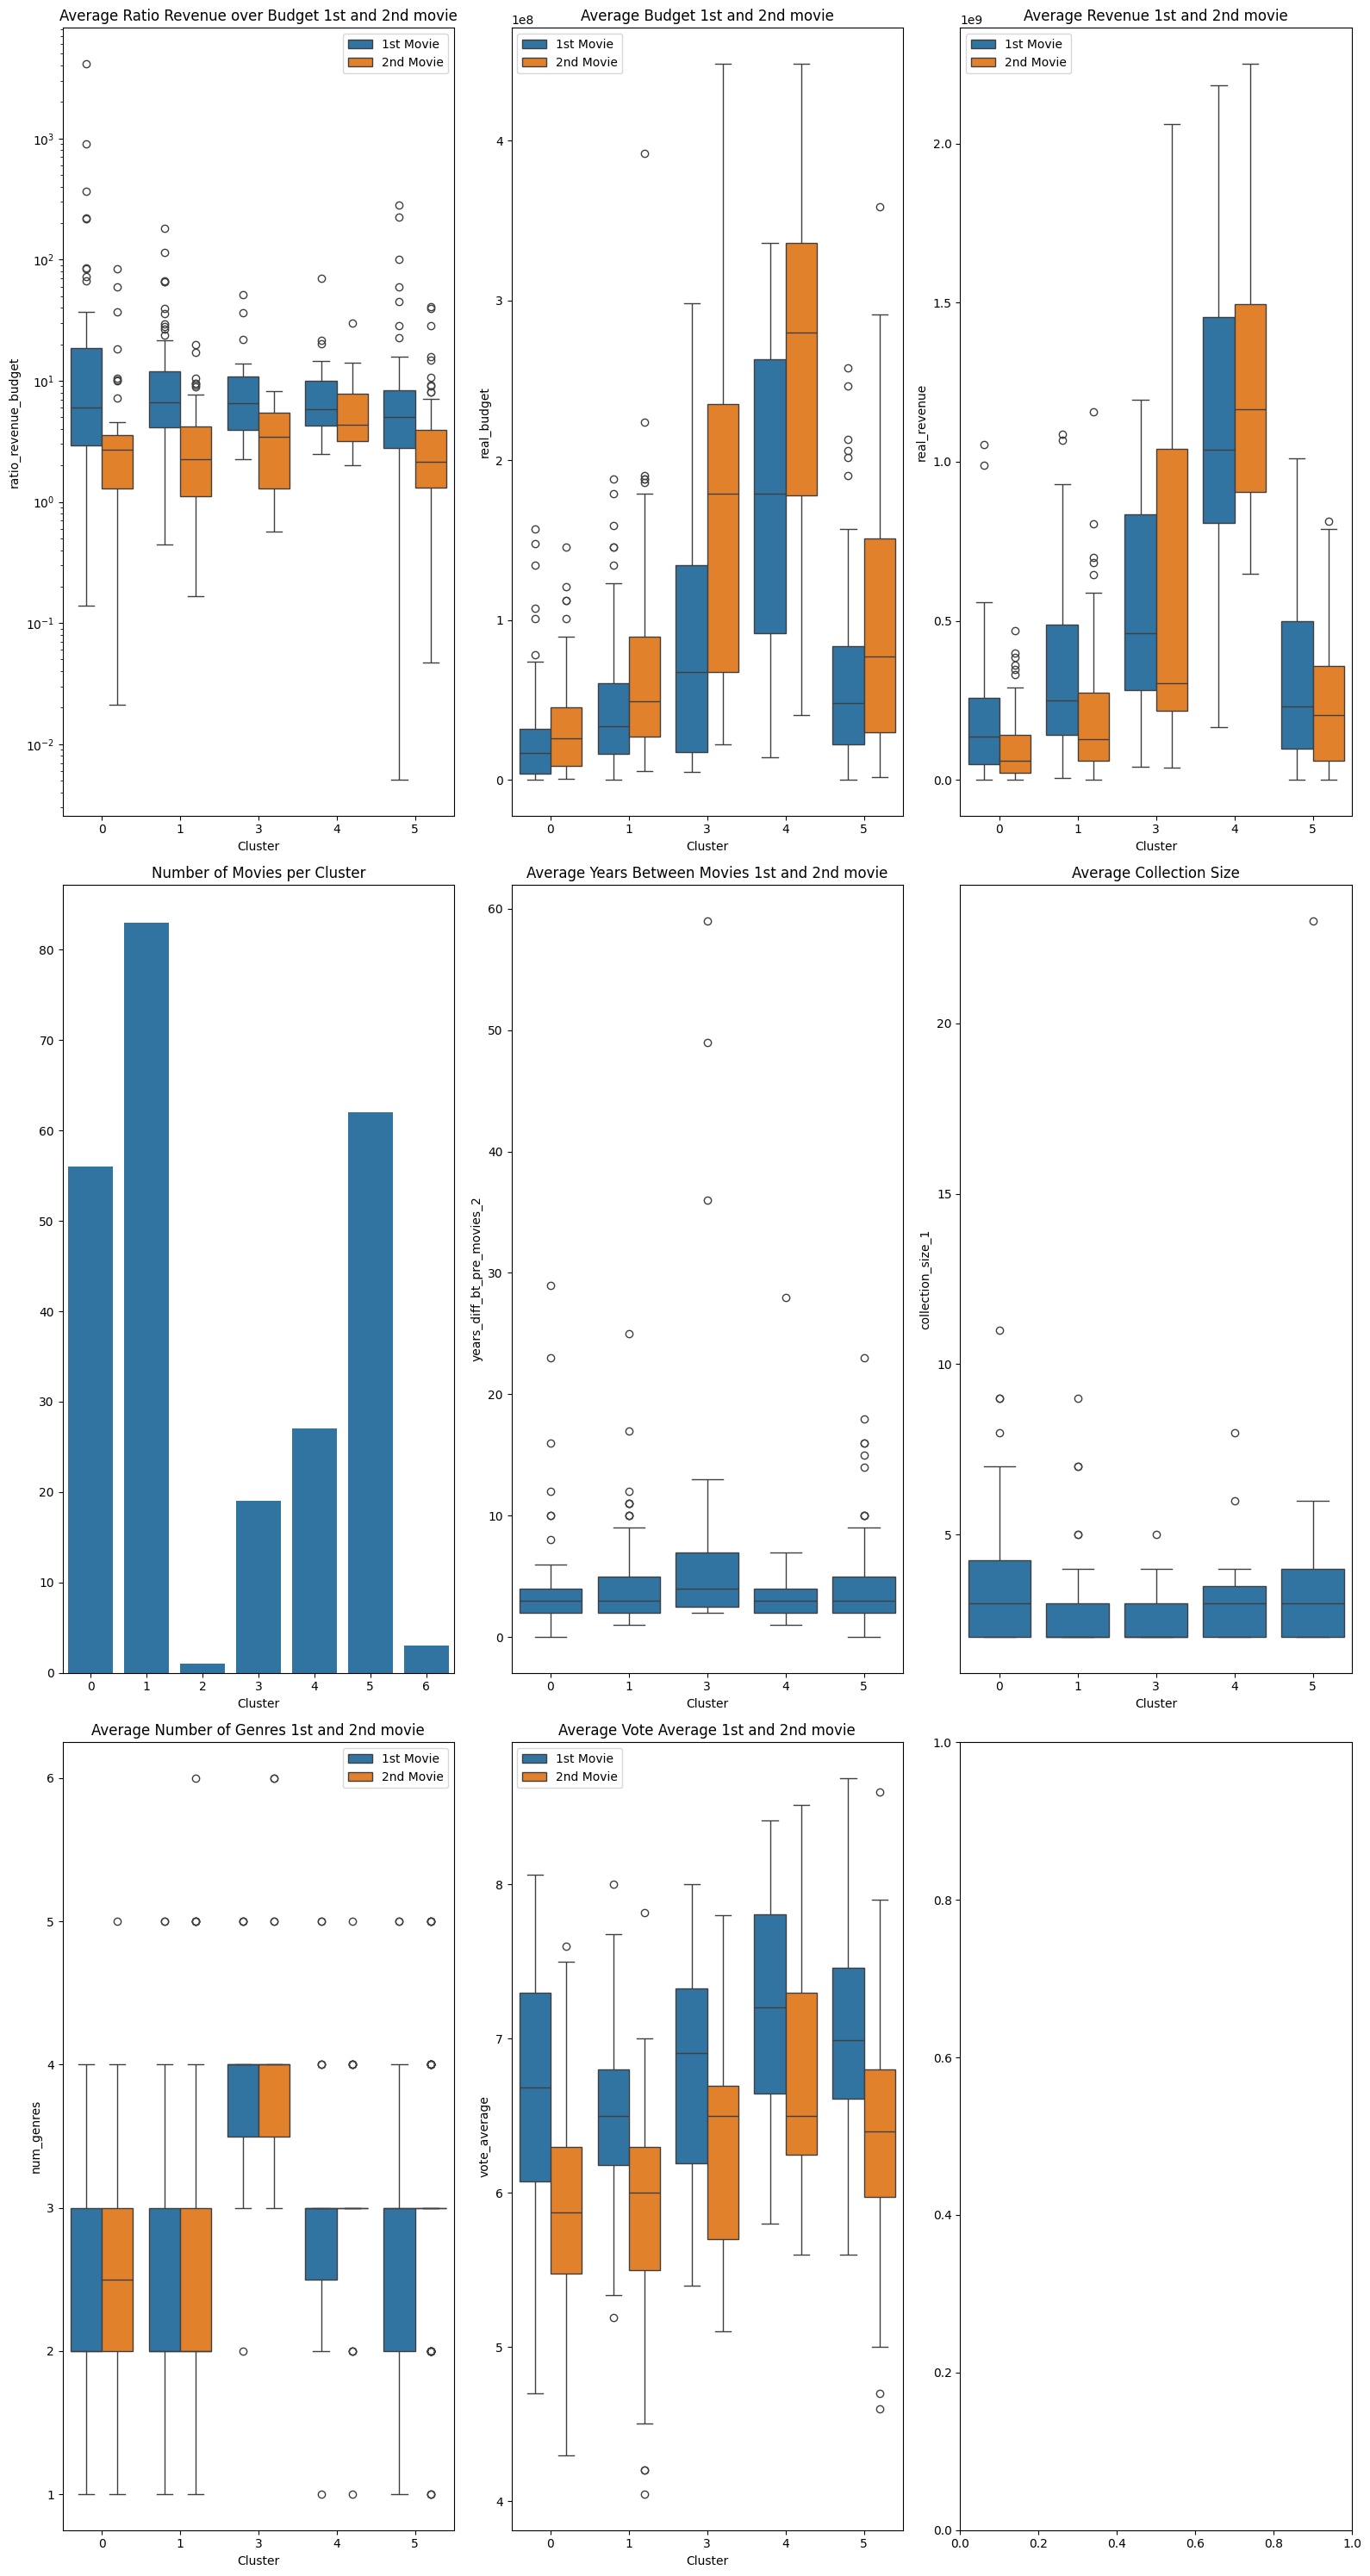

In [34]:
# Drop the cluster with less than 10 franchises idk if it is necessary
KNN_1_2_filt = KNN_1_2.groupby('Cluster').filter(lambda x: len(x) >= 5)

# Print the small cluster
print("Franchise of the cluster of less than 10 movies:")
print(KNN_1_2[~KNN_1_2['Cluster'].isin(KNN_1_2.groupby('Cluster').filter(lambda x: len(x) >= 5)['Cluster'])][['Cluster','collection_name_1','Movie name_1','Movie name_2']].sort_values(by='Cluster'))


fig, axs = plt.subplots(3, 3, figsize=(16, 30))


data_long = pd.melt(KNN_1_2_filt, id_vars='Cluster', value_vars=['ratio_revenue_budget_1', 'ratio_revenue_budget_2'],var_name='movie_nb', value_name='ratio_revenue_budget')
data_long['movie_nb']=data_long['movie_nb'].replace({'ratio_revenue_budget_1': '1st Movie', 'ratio_revenue_budget_2': '2nd Movie'})
sns.boxplot(data=data_long, x='Cluster', y='ratio_revenue_budget', hue='movie_nb', ax=axs[0,0])
axs[0,0].legend()
axs[0,0].set_title('Average Ratio Revenue over Budget 1st and 2nd movie')
axs[0,0].set_yscale('log')

data_long = pd.melt(KNN_1_2_filt, id_vars='Cluster', value_vars=['real_budget_1', 'real_budget_2'],var_name='movie_nb', value_name='real_budget')
data_long['movie_nb']=data_long['movie_nb'].replace({'real_budget_1': '1st Movie', 'real_budget_2': '2nd Movie'})
sns.boxplot(data=data_long, x='Cluster', y='real_budget', hue='movie_nb', ax=axs[0,1])
axs[0,1].legend()
axs[0,1].set_title('Average Budget 1st and 2nd movie')

data_long = pd.melt(KNN_1_2_filt, id_vars='Cluster', value_vars=['real_revenue_1', 'real_revenue_2'],var_name='movie_nb', value_name='real_revenue')
data_long['movie_nb']=data_long['movie_nb'].replace({'real_revenue_1': '1st Movie', 'real_revenue_2': '2nd Movie'})
sns.boxplot(data=data_long, x='Cluster', y='real_revenue', hue='movie_nb', ax=axs[0,2])
axs[0,2].legend()
axs[0,2].set_title('Average Revenue 1st and 2nd movie')


sns.barplot(x=KNN_1_2['Cluster'].value_counts().index, y=KNN_1_2['Cluster'].value_counts().values, ax=axs[1,0])
axs[1,0].set_title('Number of Movies per Cluster')

sns.boxplot(x='Cluster', y='years_diff_bt_pre_movies_2', data=KNN_1_2_filt, ax=axs[1,1])
axs[1,1].set_title('Average Years Between Movies 1st and 2nd movie')

sns.boxplot(x='Cluster', y='collection_size_1', data=KNN_1_2_filt, ax=axs[1,2])
axs[1,2].set_title('Average Collection Size')


data_long = pd.melt(KNN_1_2_filt, id_vars='Cluster', value_vars=['num_genres_1', 'num_genres_2'],var_name='movie_nb', value_name='num_genres')
data_long['movie_nb']=data_long['movie_nb'].replace({'num_genres_1': '1st Movie', 'num_genres_2': '2nd Movie'})
sns.boxplot(data=data_long, x='Cluster', y='num_genres', hue='movie_nb', ax=axs[2,0])
axs[2,0].legend()
axs[2,0].set_title('Average Number of Genres 1st and 2nd movie')

data_long = pd.melt(KNN_1_2_filt, id_vars='Cluster', value_vars=['vote_average_1', 'vote_average_2'],var_name='movie_nb', value_name='vote_average')
data_long['movie_nb']=data_long['movie_nb'].replace({'vote_average_1': '1st Movie', 'vote_average_2': '2nd Movie'})
sns.boxplot(data=data_long, x='Cluster', y='vote_average', hue='movie_nb', ax=axs[2,1])
axs[2,1].legend()
axs[2,1].set_title('Average Vote Average 1st and 2nd movie')

plt.tight_layout()
plt.show()



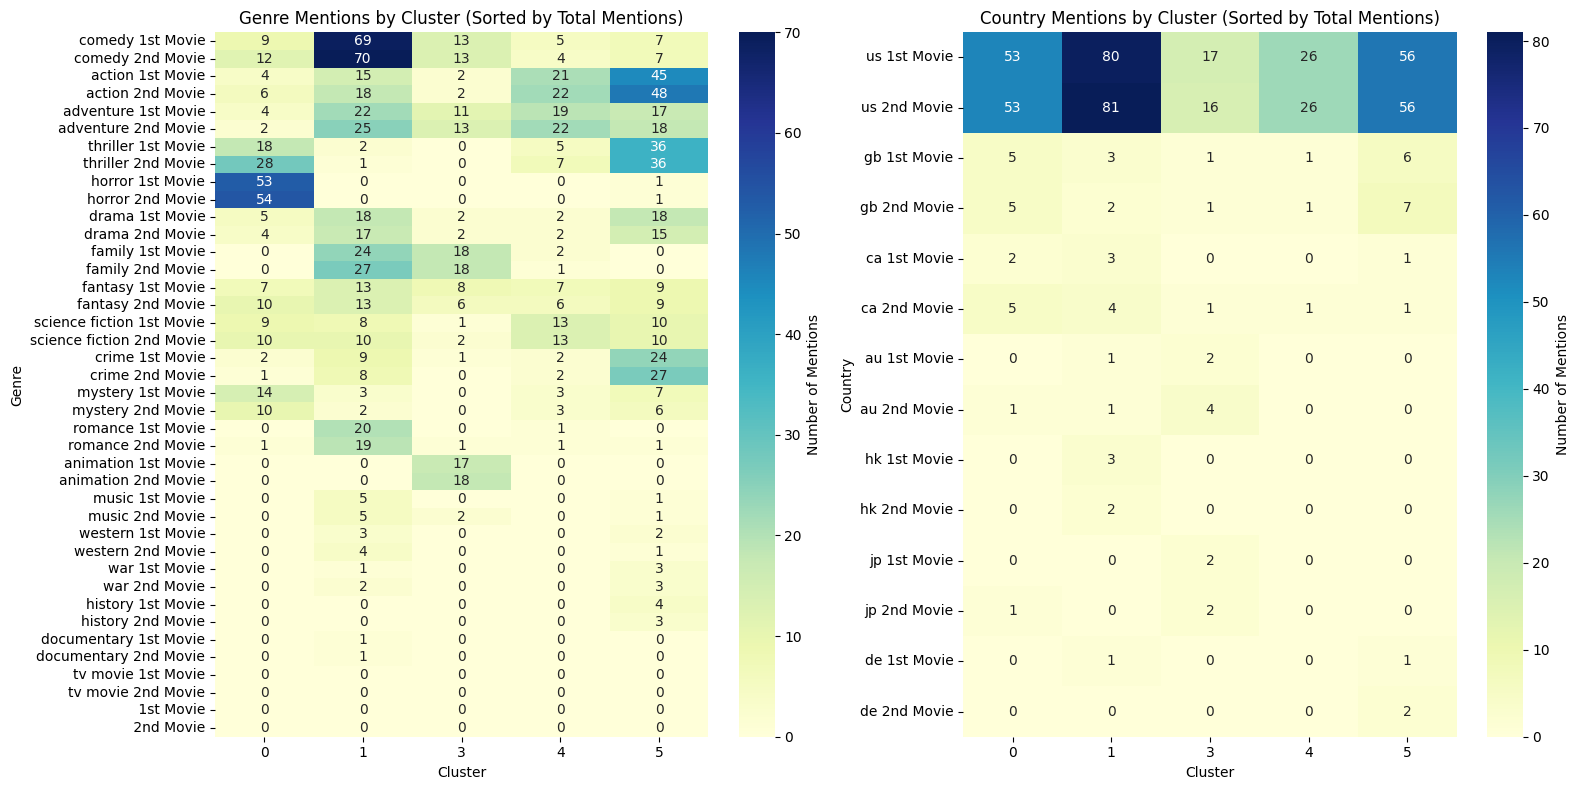

In [35]:
# Summing country of the 1st movie mentions by cluster
country_sums_1 = KNN_1_2_filt.groupby('Cluster')[
    [col for col in KNN_1_2_filt.columns if col.startswith('tmdb_origin_country_1_')]
].sum()

# Remove the 'country_' prefix from the column names
country_sums_1.columns = country_sums_1.columns.str.replace('tmdb_origin_country_1_', '')

# Sort countries by total mentions (sum across clusters)
country_sums_1 = country_sums_1.loc[:, country_sums_1.sum().sort_values(ascending=False).index]


# Summing country of the 2nd movie mentions by cluster
country_sums_2 = KNN_1_2_filt.groupby('Cluster')[
    [col for col in KNN_1_2_filt.columns if col.startswith('tmdb_origin_country_2_')]
].sum()

# Remove the 'country_' prefix from the column names
country_sums_2.columns = country_sums_2.columns.str.replace('tmdb_origin_country_2_', '')

# Sort countries by total mentions (sum across clusters)
country_sums_2 = country_sums_2.loc[:, country_sums_2.sum().sort_values(ascending=False).index]

# remove the country that are mentionned only once
country_sums_1 = country_sums_1.loc[:, country_sums_1.sum() > 1]
country_sums_2 = country_sums_2.loc[:, country_sums_2.sum() > 1]

for column in country_sums_1.columns:
    if column not in country_sums_2.columns:
        country_sums_2[column] = 0
country_sums_2 = country_sums_2[country_sums_1.columns]

# Interleave the columns (1st movie then 2nd movie for each cluster)
interleaved_columns = []
for cluster in country_sums_1.columns:
    interleaved_columns.append(country_sums_1[cluster].rename(f"{cluster} 1st Movie"))
    interleaved_columns.append(country_sums_2[cluster].rename(f"{cluster} 2nd Movie"))

# Combine into a single DataFrame
country_sums = pd.concat(interleaved_columns, axis=1)


# Summing genre mentions by cluster
genre_sums_1 = KNN_1_2_filt.groupby('Cluster')[
    [col for col in KNN_1_2_filt.columns if col.startswith('genre_1_')]
].sum()

# Remove the 'genre_' prefix from the column names
genre_sums_1.columns = genre_sums_1.columns.str.replace('genre_1_', '')

# Sort genres by total mentions (sum across clusters)
genre_sums_1 = genre_sums_1.loc[:, genre_sums_1.sum().sort_values(ascending=False).index]

# Summing genre mentions by cluster
genre_sums_2 = KNN_1_2_filt.groupby('Cluster')[
    [col for col in KNN_1_2_filt.columns if col.startswith('genre_2_')]
].sum()

# Remove the 'genre_' prefix from the column names
genre_sums_2.columns = genre_sums_2.columns.str.replace('genre_2_', '')

# Sort genres by total mentions (sum across clusters)
genre_sums_2 = genre_sums_2.loc[:, genre_sums_2.sum().sort_values(ascending=False).index]

# Interleave the columns (1st movie then 2nd movie for each cluster)
interleaved_columns = []
for cluster in genre_sums_1.columns:
    interleaved_columns.append(genre_sums_1[cluster].rename(f"{cluster} 1st Movie"))
    interleaved_columns.append(genre_sums_2[cluster].rename(f"{cluster} 2nd Movie"))

# Combine into a single DataFrame
genre_sums = pd.concat(interleaved_columns, axis=1)

# Plot the heatmap
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
sns.heatmap(
    genre_sums.T, 
    annot=True, 
    cmap='YlGnBu', 
    fmt='g', 
    cbar_kws={'label': 'Number of Mentions'},
    ax=axs[0]
)
axs[0].set_title('Genre Mentions by Cluster (Sorted by Total Mentions)')
axs[0].set_xlabel('Cluster')
axs[0].set_ylabel('Genre')

sns.heatmap(
    country_sums.T, 
    annot=True, 
    cmap='YlGnBu', 
    fmt='g', 
    cbar_kws={'label': 'Number of Mentions'},
    ax=axs[1]
)
axs[1].set_title('Country Mentions by Cluster (Sorted by Total Mentions)')
axs[1].set_xlabel('Cluster')
axs[1].set_ylabel('Country')
plt.tight_layout()
plt.show()



### Summary by cluster

Cluster -3:

In [36]:
KNN_1_2[KNN_1_2['Cluster']==-3][['collection_name_1','Movie name_1','Movie name_2']]

,collection_name_1,Movie name_1,Movie name_2


Cluster -2:

In [37]:
KNN_1_2[KNN_1_2['Cluster']==-2][['collection_name_1','Movie name_1','Movie name_2']]

,collection_name_1,Movie name_1,Movie name_2


Cluster -1:

In [38]:
KNN_1_2[KNN_1_2['Cluster']==-1][['collection_name_1','Movie name_1','Movie name_2']]

,collection_name_1,Movie name_1,Movie name_2


Cluster 1:

In [39]:
KNN_1_2[KNN_1_2['Cluster']==0][['collection_name_1','Movie name_1','Movie name_2']]

,collection_name_1,Movie name_1,Movie name_2
20,Saw Collection,Saw,Saw II
21,Blade Collection,Blade,Blade II
27,28 Days/Weeks Later Collection,28 Days Later,28 Weeks Later
35,Evil Dead Collection,The Evil Dead,Evil Dead II
37,The Grudge Collection,The Grudge,The Grudge 2
42,Jaws Collection,Jaws,Jaws 2
45,Scream Collection,Scream,Scream 2
54,I Know What You Did Last Summer Collection,I Know What You Did Last Summer,I Still Know What You Did Last Summer
67,A Nightmare on Elm Street Collection,A Nightmare on Elm Street,A Nightmare on Elm Street 2: Freddy's Revenge
72,Final Destination Collection,Final Destination,Final Destination 2


Cluster 2:

In [40]:
KNN_1_2[KNN_1_2['Cluster']==1][['collection_name_1','Movie name_1','Movie name_2']]

,collection_name_1,Movie name_1,Movie name_2
25,Austin Powers Collection,Austin Powers: International Man of Mystery,Austin Powers: The Spy Who Shagged Me
30,Teenage Mutant Ninja Turtles Collection,Teenage Mutant Ninja Turtles,Teenage Mutant Ninja Turtles II: The Secret of...
48,American Pie Collection,American Pie,American Pie 2
50,Ghostbusters Collection,Ghostbusters,Ghostbusters II
52,Ace Ventura Collection,Ace Ventura: Pet Detective,Ace Ventura: When Nature Calls
53,Dr. Dolittle Collection,Dr. Dolittle,Dr. Dolittle 2
56,Scary Movie Collection,Scary Movie,Scary Movie 2
66,The Karate Kid Collection,The Karate Kid,"The Karate Kid, Part II"
75,Bridget Jones Collection,Bridget Jones's Diary,Bridget Jones: The Edge of Reason
77,Wayne's World Collection,Wayne's World,Wayne's World 2


Cluster 3:

In [41]:
KNN_1_2[KNN_1_2['Cluster']==2][['collection_name_1','Movie name_1','Movie name_2']]

,collection_name_1,Movie name_1,Movie name_2
150,The Millennium Collection,The Girl with the Dragon Tattoo,The Girl Who Played with Fire


Cluster 4:

In [42]:
KNN_1_2[KNN_1_2['Cluster']==3][['collection_name_1','Movie name_1','Movie name_2']]

,collection_name_1,Movie name_1,Movie name_2
38,Shrek Collection,Shrek,Shrek 2
63,Ice Age Collection,Ice Age,Ice Age: The Meltdown
86,Babe Collection,Babe,Babe: Pig in the City
98,Toy Story Collection,Toy Story,Toy Story 2
130,Madagascar Collection,Madagascar,Madagascar: Escape 2 Africa
162,Pokémon Collection,Pokémon: The First Movie,Pokémon The Movie 2000
219,Peter Pan Collection,Peter Pan,Return to Never Land
220,Fantasia Collection,Fantasia,Fantasia 2000
223,Rugrats Collection,The Rugrats Movie,Rugrats in Paris: The Movie
224,The Rescuers Collection,The Rescuers,The Rescuers Down Under


Cluster 5:

In [43]:
KNN_1_2[KNN_1_2['Cluster']==4][['collection_name_1','Movie name_1','Movie name_2']]

,collection_name_1,Movie name_1,Movie name_2
0,Star Wars Collection,Star Wars Episode IV: A New Hope,Star Wars Episode V: The Empire Strikes Back
1,Indiana Jones Collection,Indiana Jones and the Raiders of the Lost Ark,Indiana Jones and the Temple of Doom
2,The Lord of the Rings Collection,The Lord of the Rings: The Fellowship of the Ring,The Lord of the Rings: The Two Towers
6,The Dark Knight Collection,Batman Begins,The Dark Knight
7,Back to the Future Collection,Back to the Future,Back to the Future Part II
10,Jurassic Park Collection,Jurassic Park,The Lost World: Jurassic Park
16,The Terminator Collection,The Terminator,Terminator 2: Judgment Day
18,Spider-Man Collection,Spider-Man,Spider-Man 2
22,X-Men Collection,X-Men,X2
26,Harry Potter Collection,Harry Potter and the Philosopher's Stone,Harry Potter and the Chamber of Secrets


Cluster 6:

In [44]:
KNN_1_2[KNN_1_2['Cluster']==5][['collection_name_1','Movie name_1','Movie name_2']]

,collection_name_1,Movie name_1,Movie name_2
4,Star Trek: The Original Series Collection,Star Trek: The Motion Picture,Star Trek II: The Wrath of Khan
5,The Godfather Collection,The Godfather,The Godfather Part II
9,Ocean's Collection,Ocean's Eleven,Ocean's Twelve
11,Predator Collection,Predator,Predator 2
19,James Bond Collection,Dr. No,From Russia with Love
24,Lethal Weapon Collection,Lethal Weapon,Lethal Weapon 2
28,Die Hard Collection,Die Hard,Die Hard 2
29,Rocky Collection,Rocky,Rocky II
31,Zorro Collection,The Mask of Zorro,The Legend of Zorro
32,Planet of the Apes (Original) Collection,Planet of the Apes,Beneath the Planet of the Apes


Cluster 7:

In [45]:
KNN_1_2[KNN_1_2['Cluster']==6][['collection_name_1','Movie name_1','Movie name_2']]

,collection_name_1,Movie name_1,Movie name_2
245,Arthur and the Invisibles Collection,Arthur and the Invisibles,Arthur and the Vengeance of Maltazard
548,Taken Collection,Taken,Taken 2
782,Spanish Apartment Trilogy,Pot Luck,The Russian Dolls


Cluster 8:

In [46]:
KNN_1_2[KNN_1_2['Cluster']==7][['collection_name_1','Movie name_1','Movie name_2']]

,collection_name_1,Movie name_1,Movie name_2


Cluster 9:

In [47]:
KNN_1_2[KNN_1_2['Cluster']==8][['collection_name_1','Movie name_1','Movie name_2']]

,collection_name_1,Movie name_1,Movie name_2


Cluster 10:

In [48]:
KNN_1_2[KNN_1_2['Cluster']==9][['collection_name_1','Movie name_1','Movie name_2']]

,collection_name_1,Movie name_1,Movie name_2


## KNN regression of the first and second movie of the franchise (that both have values for budget and revenue)

In this part we're going to try to look more specificly on how does the first and second movie interact and which common behaviour of the first movie impacts the second movie.

After some trial and errors, the KNN couldn't really separate the franchise where the 2nd movie performs better than the first one, so to make it more relevant for our analysis, we first separate the franchise where the ratio (revenue over budget) has increase from the first movie or has decreased

/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



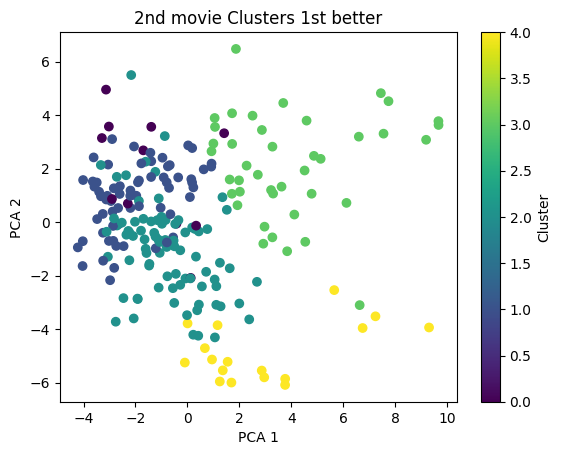

/opt/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



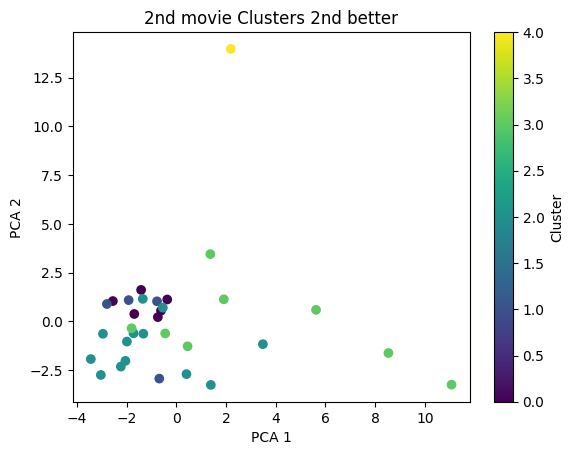

In [49]:
KNN_1_2 = get_1_2_movies(franchise_df)
KNN_1_2 = KNN_1_2.dropna(subset=['real_profit_1'])
KNN_1_2 = KNN_1_2.dropna(subset=['real_profit_2'])

# seprate the franchise where the 2nd movie has a higher ratio than the first one
KNN_1_2_2ndbetter=KNN_1_2[KNN_1_2['ratio_revenue_budget_2'] > KNN_1_2['ratio_revenue_budget_1']]
KNN_1_2_1stbetter=KNN_1_2[KNN_1_2['ratio_revenue_budget_2'] <= KNN_1_2['ratio_revenue_budget_1']]

# Load and preprocess dat
#data = KNN_1_2_other.drop(columns=['collection_id','Wikipedia movie ID_1','Wikipedia movie ID_2','Movie name_1','Movie name_2','collection_name_1','collection_name_2','genres_1','genres_2','tmdb_origin_country_1','tmdb_origin_country_2'])

data = KNN_1_2_1stbetter.drop(columns=['collection_id','Wikipedia movie ID_1','Wikipedia movie ID_2','Movie name_1','Movie name_2','collection_name_1','collection_name_2','genres_1','genres_2','tmdb_origin_country_1','tmdb_origin_country_2'])

scaler = StandardScaler()
scaled_data_1st = scaler.fit_transform(data)


# Apply K-Means
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(scaled_data_1st)

# Assign clusters back to franchise_data_df
KNN_1_2['Cluster'] = pd.NA  # Initialize Cluster column with NaN
KNN_1_2.loc[data.index, 'Cluster'] = clusters
    
# Dimensionality reduction for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data_1st)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis')
plt.title('2nd movie Clusters 1st better')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.show()

# Load and preprocess dat
data = KNN_1_2_2ndbetter.drop(columns=['collection_id','Wikipedia movie ID_1','Wikipedia movie ID_2','Movie name_1','Movie name_2','collection_name_1','collection_name_2','genres_1','genres_2','tmdb_origin_country_1','tmdb_origin_country_2'])


scaler = StandardScaler()
scaled_data_2nd = scaler.fit_transform(data)

# Apply K-Means
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(scaled_data_2nd)

# Assign clusters back to franchise_data_df
KNN_1_2.loc[data.index, 'Cluster'] = -clusters-1
    
# Dimensionality reduction for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data_2nd)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis')
plt.title('2nd movie Clusters 2nd better')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.show()


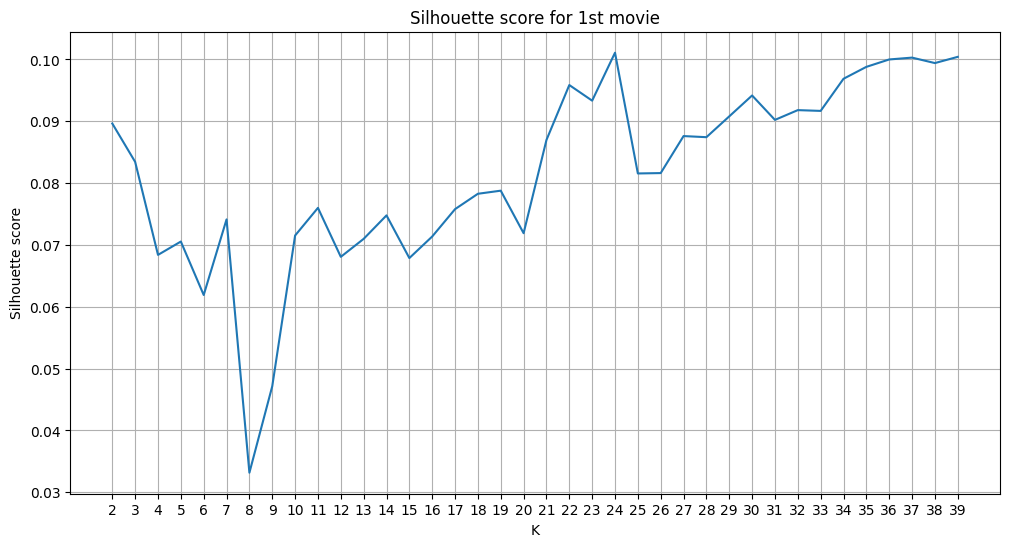

In [50]:
from sklearn.metrics import silhouette_score
silhouettes = []

# Try multiple k
for k in range(2, 40):
    # Cluster the data and assigne the labels
    clusters = KMeans(n_clusters=k, random_state=42,n_init='auto').fit_predict(scaled_data_1st)
    # Get the Silhouette score
    score = silhouette_score(scaled_data_1st, clusters)
    silhouettes.append({"k": k, "score": score})
    
# Convert to dataframe
silhouettes = pd.DataFrame(silhouettes)

# Plot the data
plt.figure(figsize=(12, 6))
plt.title('Silhouette score for 1st movie')
plt.plot(silhouettes.k, silhouettes.score)
plt.xlabel("K")
plt.ylabel("Silhouette score")
plt.grid()
plt.xticks(range(2, 40))
plt.show()

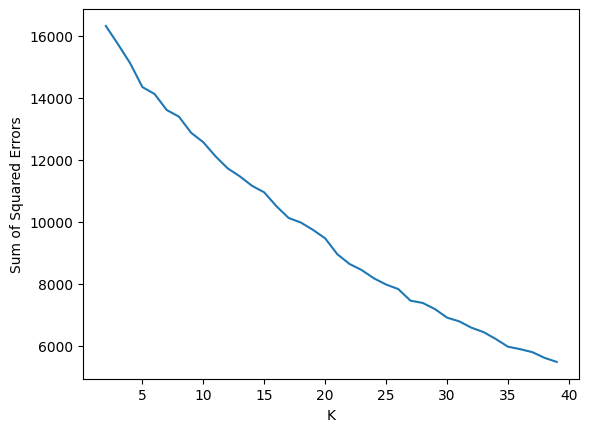

In [51]:
def plot_sse(features_X, start=2, end=40):
    sse = []
    for k in range(start, end):
        # Assign the labels to the clusters
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto').fit(features_X)
        sse.append({"k": k, "sse": kmeans.inertia_})

    sse = pd.DataFrame(sse)
    # Plot the data
    plt.plot(sse.k, sse.sse)
    plt.xlabel("K")
    plt.ylabel("Sum of Squared Errors")
    
plot_sse(scaled_data_1st)

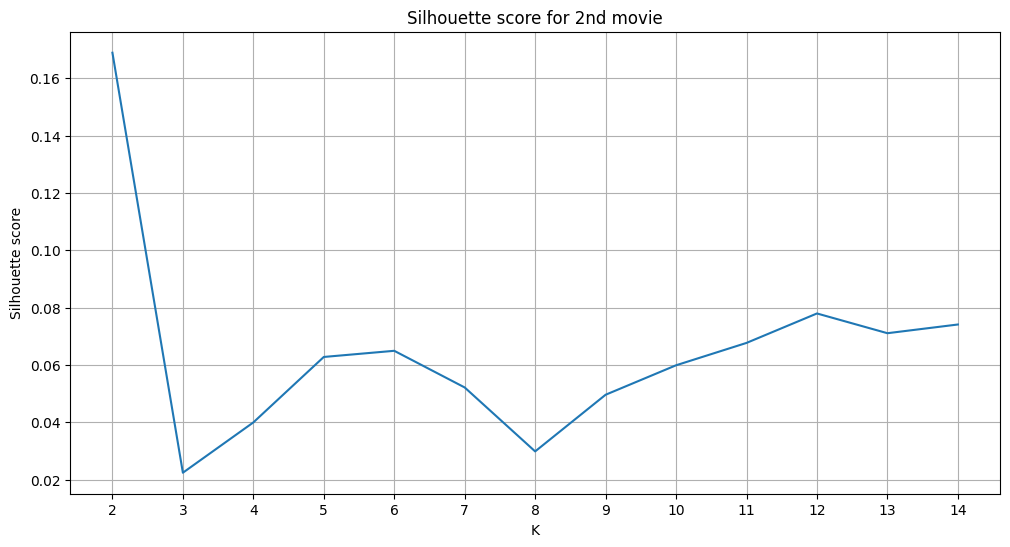

In [52]:
silhouettes = []

# Try multiple k
for k in range(2, 15):
    # Cluster the data and assigne the labels
    clusters = KMeans(n_clusters=k, random_state=42,n_init='auto').fit_predict(scaled_data_2nd)
    # Get the Silhouette score
    score = silhouette_score(scaled_data_2nd, clusters)
    silhouettes.append({"k": k, "score": score})
    
# Convert to dataframe
silhouettes = pd.DataFrame(silhouettes)

# Plot the data
plt.figure(figsize=(12, 6))
plt.title('Silhouette score for 2nd movie')
plt.plot(silhouettes.k, silhouettes.score)
plt.xlabel("K")
plt.ylabel("Silhouette score")
plt.grid()
plt.xticks(range(2, 15))
plt.show()

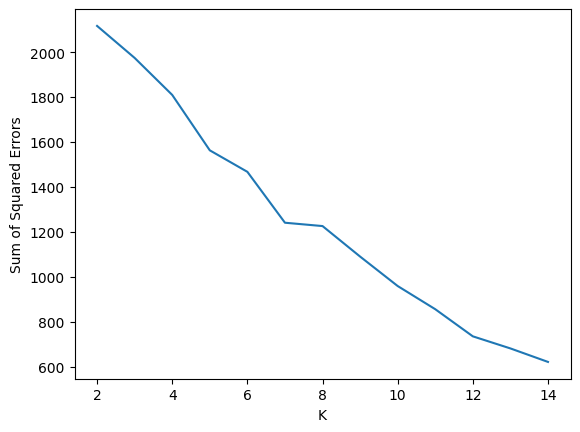

In [53]:
def plot_sse(features_X, start=2, end=15):
    sse = []
    for k in range(start, end):
        # Assign the labels to the clusters
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto').fit(features_X)
        sse.append({"k": k, "sse": kmeans.inertia_})

    sse = pd.DataFrame(sse)
    # Plot the data
    plt.plot(sse.k, sse.sse)
    plt.xlabel("K")
    plt.ylabel("Sum of Squared Errors")
    
plot_sse(scaled_data_2nd)

Using the silouhette function we found that 5 is a good number of clusters for both and it's not creating too many cluster with a little number of franchise

## Visualization of what the cluster looks like

Franchise of the cluster of less than 10 movies:
    Cluster                     collection_name_1  \
150      -5             The Millennium Collection   
51       -2           World of Watches Collection   
89       -2            The Transporter Collection   
245      -2  Arthur and the Invisibles Collection   
287      -2        The Boondock Saints Collection   

                        Movie name_1                           Movie name_2  
150  The Girl with the Dragon Tattoo          The Girl Who Played with Fire  
51                       Night Watch                              Day Watch  
89                   The Transporter                          Transporter 2  
245        Arthur and the Invisibles  Arthur and the Vengeance of Maltazard  
287              The Boondock Saints     Boondock Saints II: All Saints Day  
Note that strictly negative cluster are the ones where the 2nd movie is better than the first one, positive cluster are the opposite


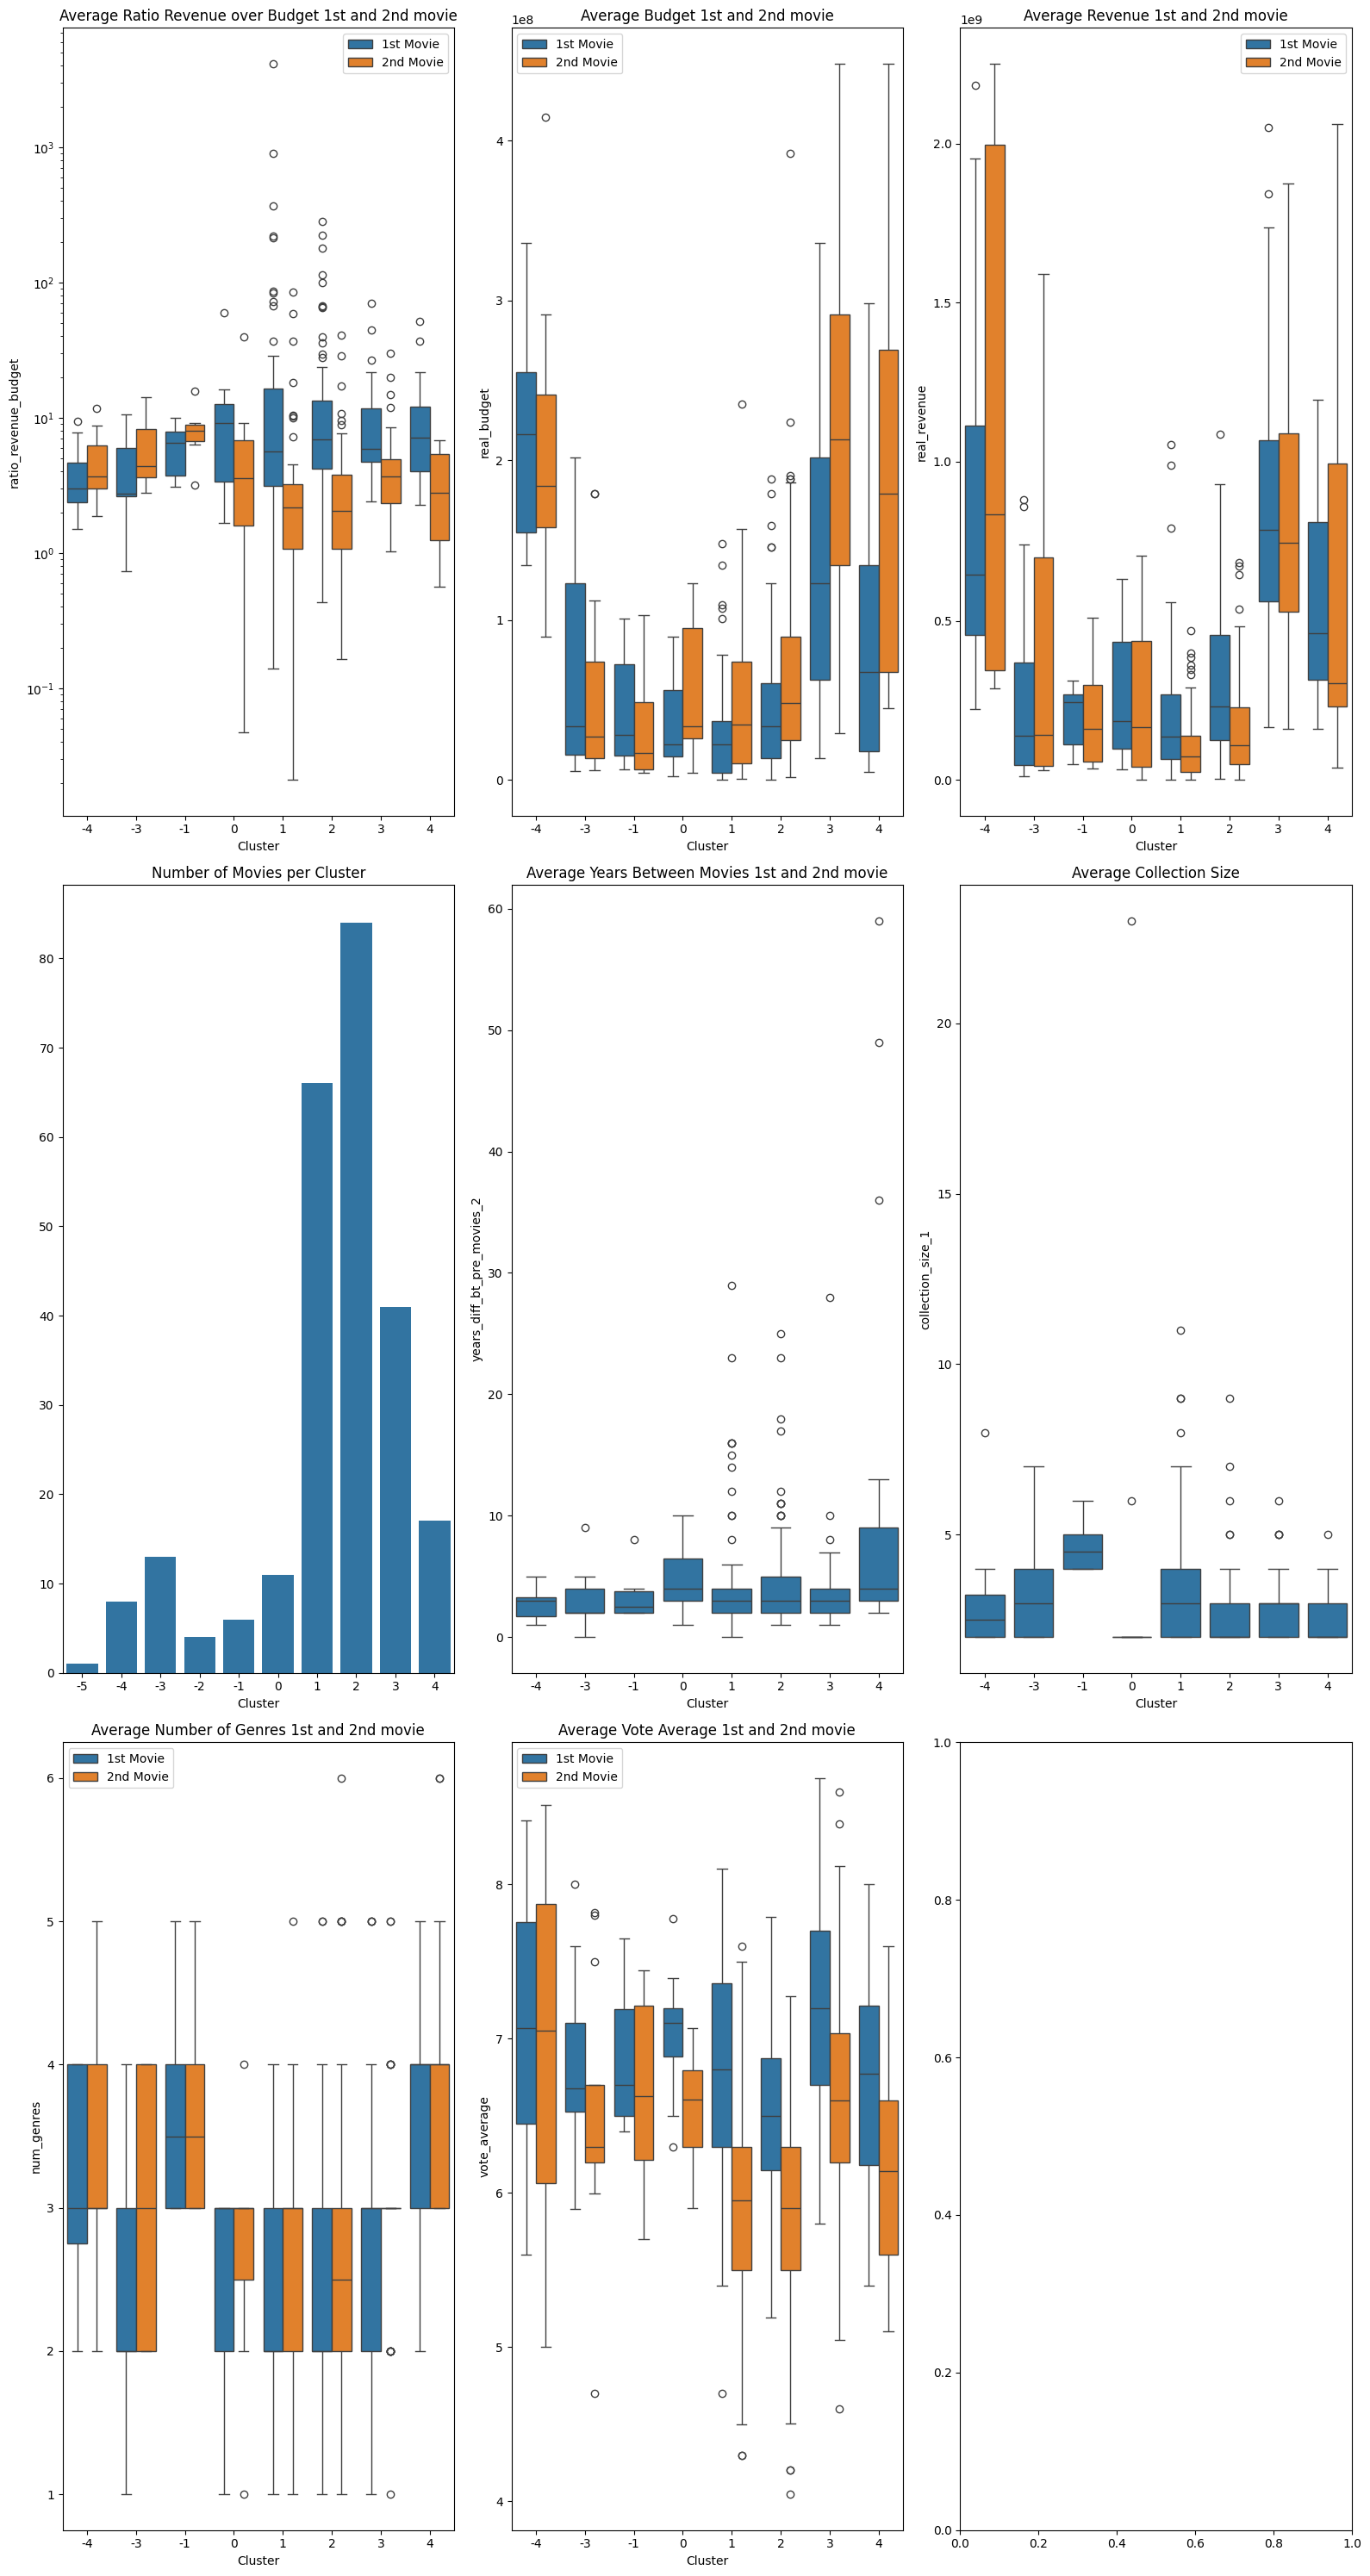

In [54]:
# Drop the cluster with less than 10 franchises idk if it is necessary
KNN_1_2_filt = KNN_1_2.groupby('Cluster').filter(lambda x: len(x) >= 5)

# Print the small cluster
print("Franchise of the cluster of less than 10 movies:")
print(KNN_1_2[~KNN_1_2['Cluster'].isin(KNN_1_2.groupby('Cluster').filter(lambda x: len(x) >= 5)['Cluster'])][['Cluster','collection_name_1','Movie name_1','Movie name_2']].sort_values(by='Cluster'))

print('Note that strictly negative cluster are the ones where the 2nd movie is better than the first one, positive cluster are the opposite')
fig, axs = plt.subplots(3, 3, figsize=(16, 30))


data_long = pd.melt(KNN_1_2_filt, id_vars='Cluster', value_vars=['ratio_revenue_budget_1', 'ratio_revenue_budget_2'],var_name='movie_nb', value_name='ratio_revenue_budget')
data_long['movie_nb']=data_long['movie_nb'].replace({'ratio_revenue_budget_1': '1st Movie', 'ratio_revenue_budget_2': '2nd Movie'})
sns.boxplot(data=data_long, x='Cluster', y='ratio_revenue_budget', hue='movie_nb', ax=axs[0,0])
axs[0,0].legend()
axs[0,0].set_title('Average Ratio Revenue over Budget 1st and 2nd movie')
axs[0,0].set_yscale('log')

data_long = pd.melt(KNN_1_2_filt, id_vars='Cluster', value_vars=['real_budget_1', 'real_budget_2'],var_name='movie_nb', value_name='real_budget')
data_long['movie_nb']=data_long['movie_nb'].replace({'real_budget_1': '1st Movie', 'real_budget_2': '2nd Movie'})
sns.boxplot(data=data_long, x='Cluster', y='real_budget', hue='movie_nb', ax=axs[0,1])
axs[0,1].legend()
axs[0,1].set_title('Average Budget 1st and 2nd movie')

data_long = pd.melt(KNN_1_2_filt, id_vars='Cluster', value_vars=['real_revenue_1', 'real_revenue_2'],var_name='movie_nb', value_name='real_revenue')
data_long['movie_nb']=data_long['movie_nb'].replace({'real_revenue_1': '1st Movie', 'real_revenue_2': '2nd Movie'})
sns.boxplot(data=data_long, x='Cluster', y='real_revenue', hue='movie_nb', ax=axs[0,2])
axs[0,2].legend()
axs[0,2].set_title('Average Revenue 1st and 2nd movie')


sns.barplot(x=KNN_1_2['Cluster'].value_counts().index, y=KNN_1_2['Cluster'].value_counts().values, ax=axs[1,0])
axs[1,0].set_title('Number of Movies per Cluster')

sns.boxplot(x='Cluster', y='years_diff_bt_pre_movies_2', data=KNN_1_2_filt, ax=axs[1,1])
axs[1,1].set_title('Average Years Between Movies 1st and 2nd movie')

sns.boxplot(x='Cluster', y='collection_size_1', data=KNN_1_2_filt, ax=axs[1,2])
axs[1,2].set_title('Average Collection Size')


data_long = pd.melt(KNN_1_2_filt, id_vars='Cluster', value_vars=['num_genres_1', 'num_genres_2'],var_name='movie_nb', value_name='num_genres')
data_long['movie_nb']=data_long['movie_nb'].replace({'num_genres_1': '1st Movie', 'num_genres_2': '2nd Movie'})
sns.boxplot(data=data_long, x='Cluster', y='num_genres', hue='movie_nb', ax=axs[2,0])
axs[2,0].legend()
axs[2,0].set_title('Average Number of Genres 1st and 2nd movie')

data_long = pd.melt(KNN_1_2_filt, id_vars='Cluster', value_vars=['vote_average_1', 'vote_average_2'],var_name='movie_nb', value_name='vote_average')
data_long['movie_nb']=data_long['movie_nb'].replace({'vote_average_1': '1st Movie', 'vote_average_2': '2nd Movie'})
sns.boxplot(data=data_long, x='Cluster', y='vote_average', hue='movie_nb', ax=axs[2,1])
axs[2,1].legend()
axs[2,1].set_title('Average Vote Average 1st and 2nd movie')

plt.tight_layout()
plt.show()



Text(8.972222222222216, 0.5, 'Genre')

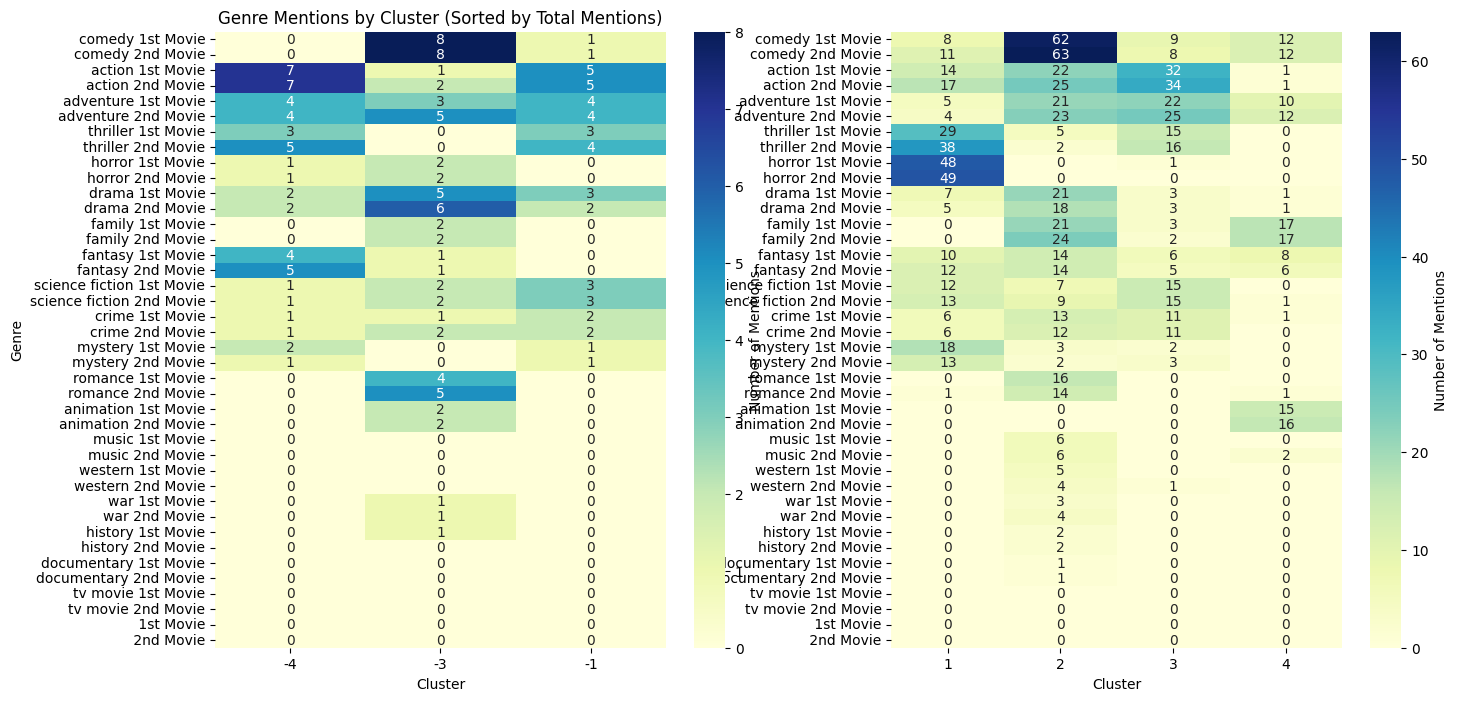

In [55]:
# Summing country of the 1st movie mentions by cluster
country_sums_1 = KNN_1_2_filt.groupby('Cluster')[
    [col for col in KNN_1_2_filt.columns if col.startswith('tmdb_origin_country_1_')]
].sum()

# Remove the 'country_' prefix from the column names
country_sums_1.columns = country_sums_1.columns.str.replace('tmdb_origin_country_1_', '')

# Sort countries by total mentions (sum across clusters)
country_sums_1 = country_sums_1.loc[:, country_sums_1.sum().sort_values(ascending=False).index]


# Summing country of the 2nd movie mentions by cluster
country_sums_2 = KNN_1_2_filt.groupby('Cluster')[
    [col for col in KNN_1_2_filt.columns if col.startswith('tmdb_origin_country_2_')]
].sum()

# Remove the 'country_' prefix from the column names
country_sums_2.columns = country_sums_2.columns.str.replace('tmdb_origin_country_2_', '')

# Sort countries by total mentions (sum across clusters)
country_sums_2 = country_sums_2.loc[:, country_sums_2.sum().sort_values(ascending=False).index]

# remove the country that are mentionned only once
country_sums_1 = country_sums_1.loc[:, country_sums_1.sum() > 1]
country_sums_2 = country_sums_2.loc[:, country_sums_2.sum() > 1]

for column in country_sums_1.columns:
    if column not in country_sums_2.columns:
        country_sums_2[column] = 0
country_sums_2 = country_sums_2[country_sums_1.columns]

# Interleave the columns (1st movie then 2nd movie for each cluster)
interleaved_columns = []
for cluster in country_sums_1.columns:
    interleaved_columns.append(country_sums_1[cluster].rename(f"{cluster} 1st Movie"))
    interleaved_columns.append(country_sums_2[cluster].rename(f"{cluster} 2nd Movie"))

# Combine into a single DataFrame
country_sums = pd.concat(interleaved_columns, axis=1)


# Summing genre mentions by cluster
genre_sums_1 = KNN_1_2_filt.groupby('Cluster')[
    [col for col in KNN_1_2_filt.columns if col.startswith('genre_1_')]
].sum()

# Remove the 'genre_' prefix from the column names
genre_sums_1.columns = genre_sums_1.columns.str.replace('genre_1_', '')

# Sort genres by total mentions (sum across clusters)
genre_sums_1 = genre_sums_1.loc[:, genre_sums_1.sum().sort_values(ascending=False).index]

# Summing genre mentions by cluster
genre_sums_2 = KNN_1_2_filt.groupby('Cluster')[
    [col for col in KNN_1_2_filt.columns if col.startswith('genre_2_')]
].sum()

# Remove the 'genre_' prefix from the column names
genre_sums_2.columns = genre_sums_2.columns.str.replace('genre_2_', '')

# Sort genres by total mentions (sum across clusters)
genre_sums_2 = genre_sums_2.loc[:, genre_sums_2.sum().sort_values(ascending=False).index]

# Interleave the columns (1st movie then 2nd movie for each cluster)
interleaved_columns = []
for cluster in genre_sums_1.columns:
    interleaved_columns.append(genre_sums_1[cluster].rename(f"{cluster} 1st Movie"))
    interleaved_columns.append(genre_sums_2[cluster].rename(f"{cluster} 2nd Movie"))

# Combine into a single DataFrame
genre_sums = pd.concat(interleaved_columns, axis=1)

# separate the negative and positive cluster
genre_sums_neg = genre_sums.T.iloc[:,0:3]
genre_sums_pos = genre_sums.T.iloc[:,4:10]


# Plot the heatmap
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
sns.heatmap(
    genre_sums_neg, 
    annot=True, 
    cmap='YlGnBu', 
    fmt='g', 
    cbar_kws={'label': 'Number of Mentions'},
    ax=axs[0]
)
axs[0].set_title('Genre Mentions by Cluster (Sorted by Total Mentions)')
axs[0].set_xlabel('Cluster')
axs[0].set_ylabel('Genre')

sns.heatmap(
    genre_sums_pos, 
    annot=True, 
    cmap='YlGnBu', 
    fmt='g', 
    cbar_kws={'label': 'Number of Mentions'},
    ax=axs[1]
)
axs[0].set_title('Genre Mentions by Cluster (Sorted by Total Mentions)')
axs[0].set_xlabel('Cluster')
axs[0].set_ylabel('Genre')


### Summary by cluster

Cluster -4:

In [56]:
KNN_1_2[KNN_1_2['Cluster']==-4][['collection_name_1','Movie name_1','Movie name_2']]

,collection_name_1,Movie name_1,Movie name_2
2,The Lord of the Rings Collection,The Lord of the Rings: The Fellowship of the Ring,The Lord of the Rings: The Two Towers
6,The Dark Knight Collection,Batman Begins,The Dark Knight
26,Harry Potter Collection,Harry Potter and the Philosopher's Stone,Harry Potter and the Chamber of Secrets
134,Hellboy Collection,Hellboy,Hellboy 2: The Golden Army
154,The Bourne Collection,The Bourne Identity,The Bourne Supremacy
212,National Treasure Collection,National Treasure,National Treasure: Book of Secrets
314,Ghost Rider Collection,Ghost Rider,Ghost Rider: Spirit of Vengeance
460,AVP Collection,AVP: Alien vs. Predator,AVPR: Aliens vs Predator - Requiem


Those are the high budget franchise that didnt had a increase in budget for the second movie and 

Cluster -3:

In [57]:
KNN_1_2[KNN_1_2['Cluster']==-3][['collection_name_1','Movie name_1','Movie name_2']]

,collection_name_1,Movie name_1,Movie name_2
25,Austin Powers Collection,Austin Powers: International Man of Mystery,Austin Powers: The Spy Who Shagged Me
63,Ice Age Collection,Ice Age,Ice Age: The Meltdown
153,Harold & Kumar Collection,Harold & Kumar Go to White Castle,Harold & Kumar Escape from Guantanamo Bay
160,The Twilight Collection,Twilight,New Moon
204,Meet the Parents Collection,Meet the Parents,Meet the Fockers
411,Firefly Collection,House of 1000 Corpses,The Devil's Rejects
425,Creepshow Collection,Creepshow,Creepshow 2
432,National Lampoon's Vacation Collection,Vacation,National Lampoon's European Vacation
505,Before... Collection,Before Sunrise,Before Sunset
742,Rebuild of Evangelion Collection,Evangelion: 1.0 You Are (Not) Alone,Evangelion: 2.0


Cluster -2:

In [58]:
KNN_1_2[KNN_1_2['Cluster']==-2][['collection_name_1','Movie name_1','Movie name_2']]

,collection_name_1,Movie name_1,Movie name_2
51,World of Watches Collection,Night Watch,Day Watch
89,The Transporter Collection,The Transporter,Transporter 2
245,Arthur and the Invisibles Collection,Arthur and the Invisibles,Arthur and the Vengeance of Maltazard
287,The Boondock Saints Collection,The Boondock Saints,Boondock Saints II: All Saints Day


Cluster -1:

In [59]:
KNN_1_2[KNN_1_2['Cluster']==-1][['collection_name_1','Movie name_1','Movie name_2']]

,collection_name_1,Movie name_1,Movie name_2
4,Star Trek: The Original Series Collection,Star Trek: The Motion Picture,Star Trek II: The Wrath of Khan
24,Lethal Weapon Collection,Lethal Weapon,Lethal Weapon 2
32,Planet of the Apes (Original) Collection,Planet of the Apes,Beneath the Planet of the Apes
128,Death Wish Collection,Death Wish,Death Wish II
161,Airport Collection,Airport,Airport 1975
457,Star Trek: The Next Generation Collection,Star Trek: Generations,Star Trek: First Contact


Cluster 1:

In [60]:
KNN_1_2[KNN_1_2['Cluster']==0][['collection_name_1','Movie name_1','Movie name_2']]

,collection_name_1,Movie name_1,Movie name_2
19,James Bond Collection,Dr. No,From Russia with Love
27,28 Days/Weeks Later Collection,28 Days Later,28 Weeks Later
34,USA: Land of Opportunities Collection,Dogville,Manderlay
75,Bridget Jones Collection,Bridget Jones's Diary,Bridget Jones: The Edge of Reason
266,Johnny English Collection,Johnny English,Johnny English Reborn
299,The Descent Collection,The Descent,The Descent 2
378,Elizabeth Collection,Elizabeth,Elizabeth: The Golden Age
398,Mr. Bean Collection,Bean,Mr. Bean's Holiday
548,Taken Collection,Taken,Taken 2
782,Spanish Apartment Trilogy,Pot Luck,The Russian Dolls


Cluster 2:

In [61]:
KNN_1_2[KNN_1_2['Cluster']==1][['collection_name_1','Movie name_1','Movie name_2']]

,collection_name_1,Movie name_1,Movie name_2
11,Predator Collection,Predator,Predator 2
20,Saw Collection,Saw,Saw II
21,Blade Collection,Blade,Blade II
35,Evil Dead Collection,The Evil Dead,Evil Dead II
37,The Grudge Collection,The Grudge,The Grudge 2
40,Underworld Collection,Underworld,Underworld: Evolution
42,Jaws Collection,Jaws,Jaws 2
45,Scream Collection,Scream,Scream 2
47,The Chronicles of Riddick Collection,Pitch Black,The Chronicles of Riddick
54,I Know What You Did Last Summer Collection,I Know What You Did Last Summer,I Still Know What You Did Last Summer


Cluster 3:

In [62]:
KNN_1_2[KNN_1_2['Cluster']==2][['collection_name_1','Movie name_1','Movie name_2']]

,collection_name_1,Movie name_1,Movie name_2
29,Rocky Collection,Rocky,Rocky II
30,Teenage Mutant Ninja Turtles Collection,Teenage Mutant Ninja Turtles,Teenage Mutant Ninja Turtles II: The Secret of...
48,American Pie Collection,American Pie,American Pie 2
50,Ghostbusters Collection,Ghostbusters,Ghostbusters II
52,Ace Ventura Collection,Ace Ventura: Pet Detective,Ace Ventura: When Nature Calls
53,Dr. Dolittle Collection,Dr. Dolittle,Dr. Dolittle 2
56,Scary Movie Collection,Scary Movie,Scary Movie 2
66,The Karate Kid Collection,The Karate Kid,"The Karate Kid, Part II"
77,Wayne's World Collection,Wayne's World,Wayne's World 2
81,Free Willy Collection,Free Willy,Free Willy 2: The Adventure Home


Cluster 4:

In [63]:
KNN_1_2[KNN_1_2['Cluster']==3][['collection_name_1','Movie name_1','Movie name_2']]

,collection_name_1,Movie name_1,Movie name_2
0,Star Wars Collection,Star Wars Episode IV: A New Hope,Star Wars Episode V: The Empire Strikes Back
1,Indiana Jones Collection,Indiana Jones and the Raiders of the Lost Ark,Indiana Jones and the Temple of Doom
5,The Godfather Collection,The Godfather,The Godfather Part II
7,Back to the Future Collection,Back to the Future,Back to the Future Part II
9,Ocean's Collection,Ocean's Eleven,Ocean's Twelve
10,Jurassic Park Collection,Jurassic Park,The Lost World: Jurassic Park
16,The Terminator Collection,The Terminator,Terminator 2: Judgment Day
18,Spider-Man Collection,Spider-Man,Spider-Man 2
22,X-Men Collection,X-Men,X2
28,Die Hard Collection,Die Hard,Die Hard 2


Cluster 5:

In [64]:
KNN_1_2[KNN_1_2['Cluster']==4][['collection_name_1','Movie name_1','Movie name_2']]

,collection_name_1,Movie name_1,Movie name_2
38,Shrek Collection,Shrek,Shrek 2
86,Babe Collection,Babe,Babe: Pig in the City
98,Toy Story Collection,Toy Story,Toy Story 2
130,Madagascar Collection,Madagascar,Madagascar: Escape 2 Africa
162,Pokémon Collection,Pokémon: The First Movie,Pokémon The Movie 2000
219,Peter Pan Collection,Peter Pan,Return to Never Land
220,Fantasia Collection,Fantasia,Fantasia 2000
223,Rugrats Collection,The Rugrats Movie,Rugrats in Paris: The Movie
224,The Rescuers Collection,The Rescuers,The Rescuers Down Under
264,Garfield Collection,Garfield: The Movie,Garfield: A Tail of Two Kitties


Cluster 6:

In [65]:
KNN_1_2[KNN_1_2['Cluster']==5][['collection_name_1','Movie name_1','Movie name_2']]

,collection_name_1,Movie name_1,Movie name_2


Cluster 7:

In [66]:
KNN_1_2[KNN_1_2['Cluster']==6][['collection_name_1','Movie name_1','Movie name_2']]

,collection_name_1,Movie name_1,Movie name_2


Cluster 8:

In [67]:
KNN_1_2[KNN_1_2['Cluster']==7][['collection_name_1','Movie name_1','Movie name_2']]

,collection_name_1,Movie name_1,Movie name_2
